#**AI@UChicago - Language Models**#

This notebook serves as a textbooks of sorts to help ground the lectures.  Sometimes, it's easier to learn at your own pace :)

##### Imports and installs

In [ ]:
%%capture
!pip install sentence-transformers
!pip install transformers

## **Section 1: Words as numbers**

### **1.1: Word Bank**

In order to begin talking about language models, we need to start by talking about language.

Specifically, how we need to represent language to machine learning models in order to get anything out of them.

As you know, computers only really "understand" numbers, so we need to figure out a method to numerically represent language.

What comes to mind naturally?

Maybe making a dictionary-sized vector and representing each word as a one-hot encoding (i.e. each word is represented by a vector of all "0" expect one "1" that represents the word).

The problem arises that there are a lot of words - around 170,000 in english - and having an algorithm reliably learn the nuances of vectors that long is challenging.

Let's think a little. "butterfly", is a combination of two words, "butter" and "fly", but there are many words that are combinations of one another, also called "portmanteaus". ("butterfly" is just an example)

As such, it makes sense to instead have *parts* of words that make up our wonderful language.

We call these parts **tokens** and the number of tokens that a given model knows the **vocabulary size**.

Usually, each token is given a unique id.

Here are some examples:

In [ ]:
%%capture
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

def tokenize_and_get_ids(sentence):
    # Load the BERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence)

    # Convert tokens to their corresponding IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    return tokens, token_ids

def display_tokens_and_ids(tokens, token_ids):
    print(f"{'Token':<12}{'Token ID'}")
    print("-" * 20)
    for token, token_id in zip(tokens, token_ids):
        print(f"{token:<12}{token_id}")

# Example usage
sentence = "Neel exclusively listens to chart-topping songs by blonde women"
tokens, token_ids = tokenize_and_get_ids(sentence)

In [ ]:
display_tokens_and_ids(tokens, token_ids)

Token       Token ID
--------------------
nee         7663
##l         2140
exclusively 7580
listen      4952
##s         2015
to          2000
chart       3673
-           1011
topping     22286
songs       2774
by          2011
blonde      9081
women       2308


So now models can identify words, but a single id number is not very informative - it gives us no information about the underlying word's nature or meaning.

### **1.2: Vectors**


In machine learning, we love vectors and matricies becasue they offer us a lot of information.

In this context, we make the simple observation that representing words by vectors encodes more information than a single number.

When thinking of word vectors, we want certain mathematical properties of vectors to match with the intuitive understanding of the word.  That is, we want addition, substraction, and cosine similarity to work.

As a little reminder, cosine similarity is defined as: for $a, b \in \mathbb{R}^n$, $$cos(\theta) = \frac{a \cdot b}{|a||b|}$$ where $\theta$ is the angle in between $a$ and $b$.  In other words, taking the cosine of the angle between two vectors is an indicator of how similar they are.

In [ ]:
%%capture
!pip install sentence-transformers

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load a pre-trained model
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
# Define a function to compute cosine similarity
def cosine_sim(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

opp = "threw"

# Define words
words = ["king", "queen", "man", "woman", opp]

# Get word vectors
vectors = {word: model.encode(word) for word in words}

# Add and subtract word vectors
king_vec = vectors["king"]
queen_vec = vectors["queen"]
man_vec = vectors["man"]
woman_vec = vectors["woman"]
opp_vec = vectors[opp]

# Example: King - Man + Woman ≈ Queen
new_vec = king_vec - man_vec + woman_vec

# Find the closest word vector to new_vec
similarities = {word: cosine_sim(new_vec, vec) for word, vec in vectors.items()}
closest_word = max(similarities, key=similarities.get)

print(f"Closest word to 'King - Man + Woman' is '{closest_word}' with cosine similarity {similarities[closest_word]:.4f}")

# Example: Cosine similarity between words
similarity_king_queen = cosine_sim(king_vec, queen_vec)
similarity_man_woman = cosine_sim(man_vec, woman_vec)

print(f"Cosine similarity between 'King' and 'Queen' is {similarity_king_queen:.4f}")
print(f"Cosine similarity between 'Man' and 'Woman' is {similarity_man_woman:.4f}")


Closest word to 'King - Man + Woman' is 'queen' with cosine similarity 0.8909
Cosine similarity between 'King' and 'Queen' is 0.6825
Cosine similarity between 'Man' and 'Woman' is 0.5491


The process of putting tokens, words, or sentences is called "embedding" or "encoding".  Each language model has it's own tokenizer (which handels embedding, too), and in order to get meaning out of sentences, models will encode each token and combine them together to form a matrix.

Mathematically, suppose we have a sequence of $n$ tokens and an embedder/tokenizer that converts those tokens into vectors of dimension $d_{model}$.

Our actual under-the-hood input to the model, then, would be a matrix $ X \in \mathbb{R}^{n \: \times \: d_{model}}$.  

And that's why word vectors are so important: becasue they make up the core of how language models understand words.

## **Section 2: A little game**

### **2.1: Fill in the Blank**

To first understand large language models, we mist first understand **attention**.

Consider: Hung tried to sleep but his [MASK] was too loud.

What is "[MASK]"?  

Maybe these sentences are easier:

*   Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.
*   Hung tried to sleep, but his [MASK] kept barking at nothing.
*   Hung tried to sleep, but his [MASK] kept ringing.


Why are these easier?





### **2.2: Machines can also play this game**

In [8]:
%%capture
# DON'T WORRY ABOUT THIS STUFF NOW, WE WILL GET TO IT LATER!
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

model_name = "bert-base-uncased"  # Replace with a model trained for masked language modeling
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

def predict_word(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt")

    # Find the position of the [MASK] token
    mask_token_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)[0]

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted token probabilities
    logits = outputs.logits
    mask_token_logits = logits[0, mask_token_index, :]

    # Get the top 3 tokens
    top_3_tokens = torch.topk(mask_token_logits, 3, dim=1)

    # Print the results
    print(f"\nSentence: {sentence}")
    print("Top 3 predictions:")
    for i, (token_id, prob) in enumerate(zip(top_3_tokens.indices[0], top_3_tokens.values[0])):
        token = tokenizer.decode([token_id])
        probability = torch.softmax(mask_token_logits, dim=1)[0, token_id].item()
        print(f"{i+1}. {token:<10} (Probability: {probability:.4f})")

In [9]:
sentences = [
    "Hung tried to sleep but his [MASK] was too loud.",
    "Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.",
    "Hung tried to sleep, but his [MASK] kept barking at nothing.",
    "Hung tried to sleep, but his [MASK] kept ringing."
]

for sentence in sentences:
    predict_word(model, tokenizer, sentence)


Sentence: Hung tried to sleep but his [MASK] was too loud.
Top 3 predictions:
1. voice      (Probability: 0.1935)
2. breathing  (Probability: 0.0887)
3. dream      (Probability: 0.0768)

Sentence: Hung tried to sleep, but his [MASK] was talking to his girlfriend the whole night.
Top 3 predictions:
1. father     (Probability: 0.2311)
2. dad        (Probability: 0.2033)
3. brother    (Probability: 0.1520)

Sentence: Hung tried to sleep, but his [MASK] kept barking at nothing.
Top 3 predictions:
1. dog        (Probability: 0.4576)
2. mother     (Probability: 0.0553)
3. stomach    (Probability: 0.0393)

Sentence: Hung tried to sleep, but his [MASK] kept ringing.
Top 3 predictions:
1. ears       (Probability: 0.6666)
2. phone      (Probability: 0.2349)
3. head       (Probability: 0.0517)


### **2.3: How machines play**

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

def strip_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def show_weights(model, tokenizer, sentence, exclude = True):
    # Strip punctuation and tokenize the input sentence
    stripped_sentence = strip_punctuation(sentence)
    inputs = tokenizer(stripped_sentence, return_tensors="pt")

    # Get the attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Get the attention weights from the last layer
    attention = outputs.attentions[-1].squeeze()

    # Average the attention across all heads
    attention = attention.mean(dim=0)

    # Get the tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Find the positions of [CLS] and [SEP] tokens
    cls_position = tokens.index('[CLS]')
    sep_position = tokens.index('[SEP]')

    # Remove the [CLS] and [SEP] tokens from tokens and attention matrix
    attention = attention.numpy()
    if exclude:
        tokens = tokens[cls_position+1:sep_position]
        attention = np.delete(attention, [cls_position, sep_position], axis=0)
        attention = np.delete(attention, [cls_position, sep_position], axis=1)

    # Renormalize the attention weights
    attention = attention / attention.sum(axis=-1, keepdims=True)

    # Create a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(attention, cmap="YlOrRd", annot=False,
                xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Attention weights matrix for:\n{sentence}")
    plt.xlabel("Key Tokens (attended to)", fontsize=12)
    plt.ylabel("Query Tokens (attending)", fontsize=12)

    plt.tight_layout()
    plt.show()

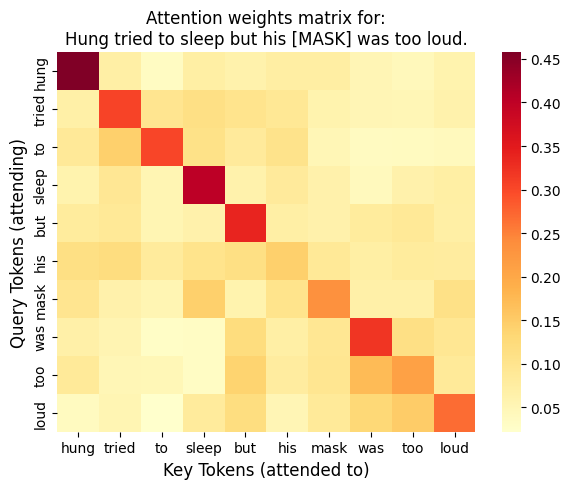

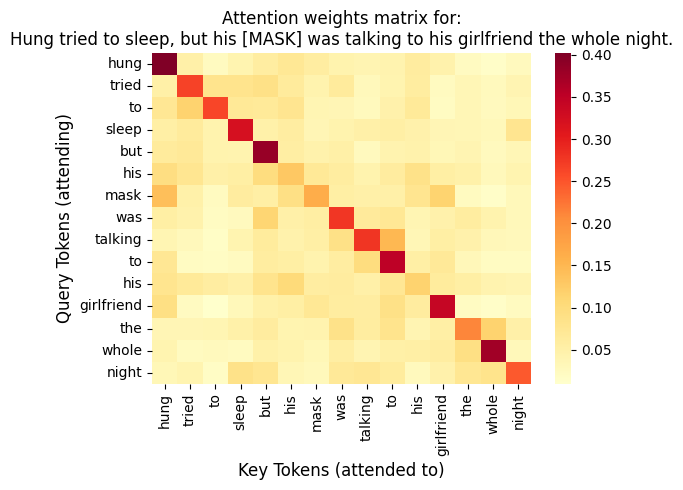

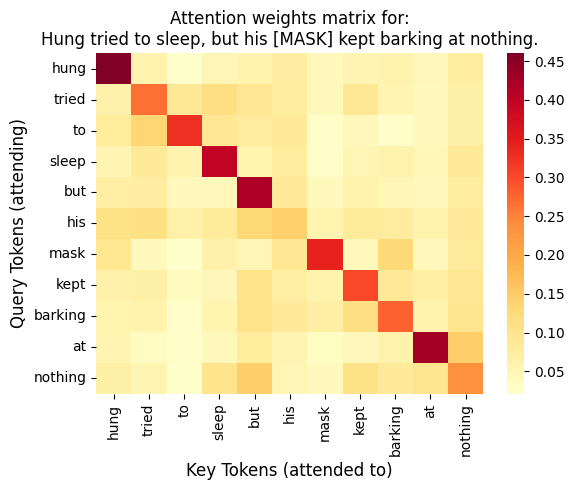

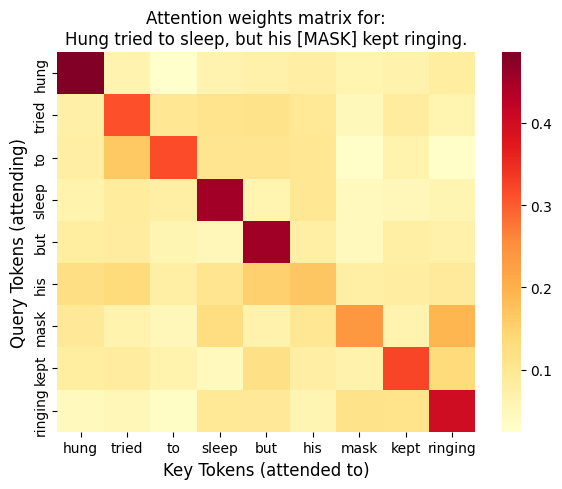

In [ ]:
for sentence in sentences:
    show_weights(model, tokenizer, sentence)

Models pay "attention" to certain words in the sentence that inform the probabilities for the mask.  Humans somewhat do the same thing too; we look at words like "girlfriend", "barking", and "ringing" which tip us off.

We can see in the heatmaps what these models pay attention to, and even though it might not line up excactly with humans, there are some intuitive relations.

Speaking of which, we read the heatmaps as such: each token has their own attention values with all tokens in the sequence, including itself.  We read each row of the heatmaps as the token who's attention values are taken into consideration and the columns as the tokens being attended to.

**Note:**
Models actually learn attention by playing this game of "guess the token" and backpropogating towards the ground truth answer.

## **Section 3: Queries, Keys, and Values**

### **3.1: Intuition for QKV**

**Note:** there are other kinds of attention mechanisms, but or sake of time, we will only pay attention to original type of attention, which is the progenitor of the rest.

The kind we will be looking at is called **"scaled dot product attention"**.

At the heart of scaled dot product attention are **keys** (K), **queries** (Q), and **values** (V).

If you know python dictionaries, then you already know query, key, value relationships.

When you have a query, you compare it to each key, and when the query fits the key, you take the corresponding value.

In [1]:
# If you know python, you're already familiar with some version of QKV: dictionaries

Q = "K2"

D = {
    "K1": "V1",
    "K2": "V2",
    "K3": "V3"
}

print(D[Q])

V2


### **3.2: Attention by QKV: the math**

In attention, though, we care more about how *well* a query fits with a particular key, which will determine the how we weight the corresponsing value.

Let's say that we have a sentence of length $n$ tokens.

Naturally, that means we'd want $n$ key vectors and $n$ corresponsding value vectors, meaning one key and one value vector for each token.  In natural language processing (NLP), pretty much everything is a vector because we can encode complex linguistic relationships in high dimentional vectors.

Suppose:

*   $n$ query vectors $q_i$, with dimension $d_q$
*   $n$ key vectors, $k_i$, with dimension $d_q$
*   $n$ corresponsing value vectors, $v_i$, with dimension $d_v$

Note that we don't necessarily need $d_q = d_v$, but we abolutely need the key and query vectors to be the same dimension.

Then we end up having
*   Query matrix $Q \in \mathbb{R}^{n \, \times \, d_q }$
*   Key matrix $K \in \mathbb{R}^{n \, \times \, d_q }$
*   Value matrix $V \in \mathbb{R}^{n \, \times \, d_v }$

In order to understand the compatibility between the queries and keys, we need to multiply the matricies, which we do by $QK^T$.

We normalize this value by dimension since if we increase the dimension, the values in $QK^T$ can get arbitrarily large.

Thus we have $\frac{QK^T}{\sqrt{d_q}} \in \mathbb{R}^{n \, \times \, n }$.

We're still not done with normalizaiton, though, as we want to make sure that the values in each row are normalized and positive.  To accomplish this, we use a probability distribuiton tool called "softmax", denoted $\sigma:\mathbb{R}^n \rightarrow (0, 1]^n$.

$$\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{n}exp(z_j)}$$

We apply softmax row-wise to obtain: $$\sigma(\frac{QK^T}{\sqrt{d_q}})\in \mathbb{R}^{n \, \times \, n }$$.

Now, all rows add to one and are positive.

Lastly, it's a simple step to perform matrix multiplication with $V$, which essentially tells us how *important* each connection is, while $\sigma(\frac{QK^T}{\sqrt{d_q}})$ tells us how *strong* the connection is.

So, finally, we get: $$Attention(Q, K, V) = \sigma(\frac{QK^T}{\sqrt{d_q}})V \in \mathbb{R}^{n \, \times \, d_v }$$

**This is our formula for scaled dot product attention.**

### **3.3: Attention by QKV: the code for $\sigma(\frac{QK^T}{\sqrt{d_q}})$**

In [7]:
# Let's code it
from transformers import BertModel, BertTokenizer
import math
import torch

class Attention:
    def __init__(self, model_name = 'bert-base-uncased', tokenizer_name = 'bert-base-uncased'):
        self.model = BertModel.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

    def get_QK_T(self, sentence: str):
        tokens = self.tokenizer.tokenize(sentence)
        print("Tokens:", tokens)

        ids = []

        for token in tokens:
            id = self.tokenizer.convert_tokens_to_ids(token)
            ids.append(id)

        print("How the computer sees the tokens", ids)

        d_q = 1

        input_ids = torch.tensor(ids).unsqueeze(0)
        with torch.no_grad():
            outputs = self.model(input_ids)
            embeddings = outputs.last_hidden_state[0]
        print("Vector representation dimensions:", len(embeddings),"by", len(embeddings[0]))

        d_q = len(embeddings[0])

        print("\nHere, we're going to be a bit cheap and set Q and K as the same vector reprentation. \nThis is NOT how it's done in the field, which we'll see next class.")

        Q = embeddings
        K_T = torch.transpose(embeddings, 0, 1)

        QK = torch.matmul(Q, K_T)

        print("")

        return QK, d_q

    def normalize_QK_T(self, QK_T, d_q):
        div_d_q = torch.div(QK_T, math.sqrt(d_q))

        softmaxed = torch.nn.functional.softmax(div_d_q, 0)

        return softmaxed


In [8]:
s = "You are the key to my query"

attn = Attention(model_name='bert-base-uncased', tokenizer_name='bert-base-uncased')

QK_T, d_q = attn.get_QK_T(s)

print("Q(K^T) dimension:", QK_T.size())
print("Q(K^T):\n", QK_T)

N = attn.normalize_QK_T(QK_T, d_q)

print("\nNormalized Q(K^T):\n", N)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokens: ['you', 'are', 'the', 'key', 'to', 'my', 'query']
How the computer sees the tokens [2017, 2024, 1996, 3145, 2000, 2026, 23032]
Vector representation dimensions: 7 by 768

Here, we're going to be a bit cheap and set Q and K as the same vector reprentation. 
This is NOT how it's done in the field, which we'll see next class.

Q(K^T) dimension: torch.Size([7, 7])
Q(K^T):
 tensor([[145.2904, 124.2025, 107.2782, 107.7140,  93.5499,  96.8252, 102.4099],
        [124.2025, 150.7934, 124.4207, 121.7916, 106.7936,  96.2314, 104.9211],
        [107.2782, 124.4207, 171.6270, 124.5788, 114.1441,  91.9515,  91.5665],
        [107.7140, 121.7916, 124.5788, 142.7945, 119.0422, 103.7349, 114.3812],
        [ 93.5499, 106.7936, 114.1441, 119.0422, 144.4766, 112.0527, 111.1005],
        [ 96.8252,  96.2314,  91.9515, 103.7349, 112.0527, 160.0919, 132.1034],
        [102.4099, 104.9211,  91.5665, 114.3812, 111.1005, 132.1034, 153.2335]])

Normalized Q(K^T):
 tensor([[0.3968, 0.1443, 0.0577, 0.085

In [18]:
%%capture
!pip install matplotlib
!pip install seaborn

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_heatmap(tensor, sentence, tokenizer, title="Heatmap"):
    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence)

    # Convert tensor to numpy array
    if isinstance(tensor, torch.Tensor):
        matrix = tensor.detach().cpu().numpy()
    else:
        matrix = np.array(tensor)

    # Ensure the matrix is 2D
    if matrix.ndim == 1:
        matrix = matrix.reshape(1, -1)

    # Trim or pad the matrix to match the number of tokens
    n_tokens = len(tokens)
    if matrix.shape[0] > n_tokens:
        matrix = matrix[:n_tokens, :n_tokens]
    elif matrix.shape[0] < n_tokens:
        pad_width = ((0, n_tokens - matrix.shape[0]), (0, n_tokens - matrix.shape[1]))
        matrix = np.pad(matrix, pad_width, mode='constant', constant_values=0)

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=False, cmap="YlOrRd", xticklabels=tokens, yticklabels=tokens)

    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

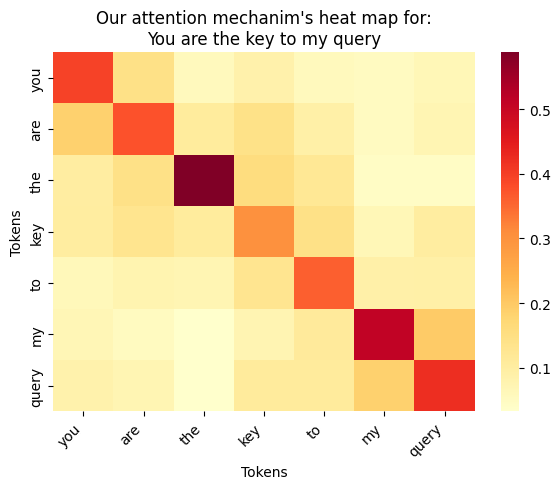

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


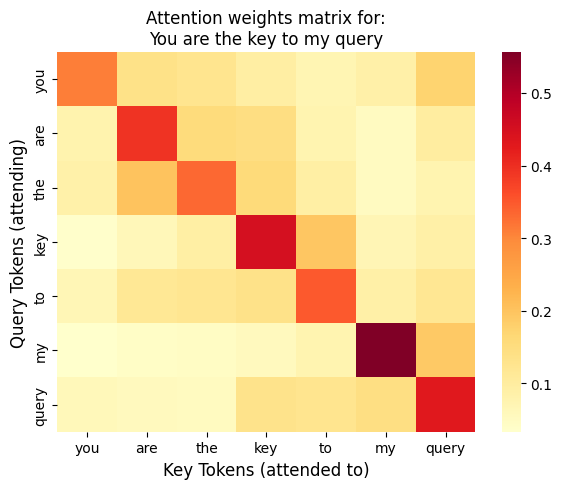

In [23]:
create_heatmap(N, s, attn.tokenizer, title=f"Our attention mechanim's heat map for:\n{s}")

# show_weights is defined in 2.3
show_weights(attn.model, attn.tokenizer, s)

We can see that they share similar patterns, but they aren't identical.

One reason is that we cheated and set $Q$ = $K$

The other reason is that BERT, the model we're using, does more than just scaled dot product under the hood.  In fact, it uses something called, **multi-head attention**, which we'll learn about next.

### **3.4: Conclusion of QKV**

That's most of the hard work done.

If you're asking why I'm not implementing the matrix multiplicaiton of $V$ at the end, it's becasue the values matrix is something that must be *learned*.  In practice, we'd need to learn $Q$ and $K$ too, but we improvised/estimated those values to demonstrate how the math works.

I'll end with a graphic used to desribe attention in the original paper, "[Attention is all you need](https://arxiv.org/pdf/1706.03762)".

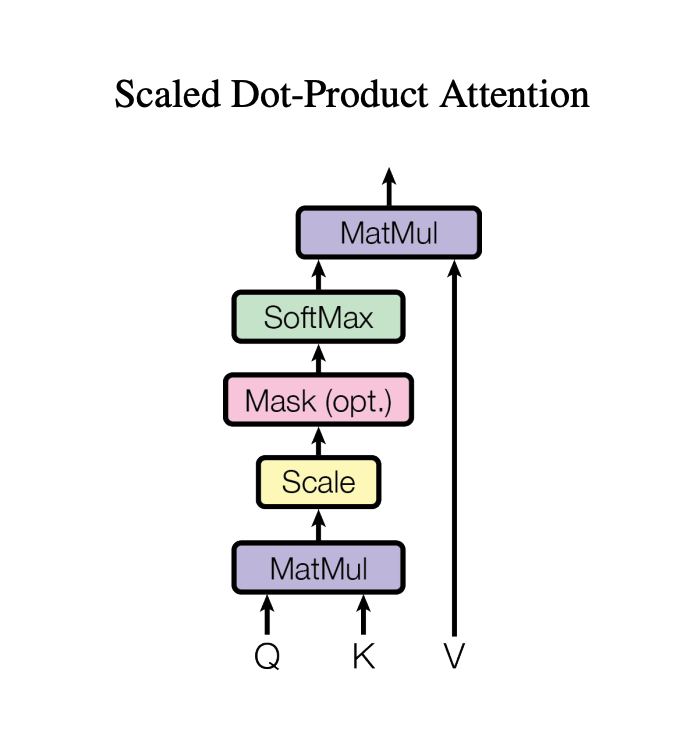

## **Section 4: Multi-head attention (MHA)**

### **4.1: Intuition for multi-head attention**

One node of attention, i.e. one $\sigma(\frac{QK^T}{\sqrt{d_q}})V$, is called one attention head. Why have one when you can have multiple, though?

Researches have found that performance increases when we linearly project the input down to certain learned features.  

More concretely, we have low dimension weight matricies of that represent certain features to pay attention to.  We don't know what there features are a priori - the weight matrices are learned during training.

However, if we multiply our input by the weight matrices (which, in linear algebra terms, could be called a projection), we end up getting many different matrices, which we then use QKV attention with.  Each one of these operations is called an attention head.

At the end, we take those outputs of each head and just stick them together, thereby acheiving multi-head attention.



### **4.2: The math for multi-head attention**

We start with an input matrix $\: X \in \mathbb{R}^{n \: \times \: d_{model}}$ where $n$ is the sequence length and $d_{model}$ is the embedding length, or the dimension of the vector representation of each token.

Let $h$ be the number of attention heads that we're dealing with.  We'd want $d_{model} % h = 0$ becasue we define $d_{head} = \frac{d_{model}}{h}$.

$d_{head}$ is the dimension that we want to project down to for each head.  We reduce the dimension for each head since it is computationally less expenive while not sacrificing performance.

We have three lists of weights:
*   Queries: $\{W_1^Q ,..., W_h^Q\} \: s.t. \: W_i^Q \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$
*   Keys: $\{W_1^K ,..., W_h^K\} \: s.t. \: W_i^K \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$
*   Values: $\{W_1^V ,..., W_h^V\} \: s.t. \: W_i^V \in \mathbb{R}^{d_{model} \: \times \: d_{head}}$

At this point, it's worth noting the two different ways which MHA is often explained and implemented.  I will show you both and you can think of MHA in whichever way makes more sense to you.

#### **4.2.1: Many matrix MHA**

Given how I've set the theory up, this method seems more intuitive to me.

We continue by finding the queries, keys, and values for each attention head in the way you'd expect:
$$Q_i = XW_i^Q \in \mathbb{R}^{n \: \times \: d_{head}}$$
$$K_i = XW_i^K \in \mathbb{R}^{n \: \times \: d_{head}}$$
$$V_i = XW_i^V \in \mathbb{R}^{n \: \times \: d_{head}}$$

so that we can now define $head_i = Attention(Q_i, K_i, V_i) \in \mathbb{R}^{n \: \times \: d_{head}}$

and Multi head attention as $$matmul(concat(head_1, ..., head_h), W^O)$$

where $W^O \in \mathbb{R}^{h*d_{head} \: \times \: d_{model}}$ is a weight matrix designed to scale the output back to $\mathbb{R}^{n \: \times \: d_{model}}$

#### **4.2.2: One big matrix**

Another way that MHA is set up in pactice and theory is having one big matrix got Q, K, V rather than $h$ different ones.

We can do that by having large weight matrices:

*   $W^Q \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$
*   $W^K \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$
*   $W^V \in \mathbb{R}^{d_{model} \: \times \: h*d_{head}}$

Whch means:

*   $Q = X W^Q \in \mathbb{R}^{n \: \times \: h*d_{head}}$
*   $K = X W^K \in \mathbb{R}^{n \: \times \: h*d_{head}}$
*   $V = X W^V \in \mathbb{R}^{n \: \times \: h*d_{head}}$

So then we can do: $$MultiHeadAttention(Q, K, V) = matmul(Attention(Q, K, V), \: W^O)$$

Where again, $W^O \in \mathbb{R}^{h*d_{head} \: \times \: d_{model}}$ servers to return the multi-head attention back to $\mathbb{R}^{n \: \times \: d_{model}}$ as somewhat of a re-normalization.

#### **4.2.3: Pros and cons**

Your choice to use either version of MHA depends on first and foremost, your understanding of each.  They are mathematically equivalent and theoretically provide no difference.

In practice, you're honestly never even going to touch attention, but if you ever do need to implement it, you should pick based on your resoruces.


**Low RAM:** If you have low memory, multiple little heads are better since there are less calculations that need to be done all at once.  Consequently, you will be forced to perform all those matrix operations sequentially which will take a lot of time.

**High RAM:**. If you have memory to spare, the large matrix multiplication consumes a lot of RAM, but it will be done much quicker since it takes $h$ times fewer operations.

Again, you will might never actually care about which type of multi-head attention you're using, nor will you usually know.  I just had us think of these things becasue in ML (and CS in general), one has to constantly make decisions about speed vs compute.

### **4.3: Implementation of multi-head attention**

In [24]:
# Sources: 1) https://nlp.seas.harvard.edu/annotated-transformer/, 2) https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy
import typing
from typing import Union, Optional, Tuple



# This class defines every method we will need for working with masking in our MHA block.
class MaskingMechanism:
  @staticmethod
  def decoder_mask(size : int) -> torch.Tensor:
    '''Mask for the decoder. Size refers to the token sequence length of the input to the decoder.'''
    attention_shape = (1, size, size)
    mask = torch.tril(torch.ones((1,size,size)), diagonal=0)
    return mask

  @staticmethod
  def expand_mask(mask : torch.Tensor) -> torch.Tensor:
    '''Expand mask to 4 dimensions. This method is modified to deal with both 2d and 3d masks.'''
    assert mask.ndim >= 2
    if mask.ndim == 3:  # Assuming we just need to add a 'num_heads' dim.
      mask = mask.unsqueeze(1)
    while mask.ndim < 4:
      mask = mask.unsqueeze(0)
    return mask



# This class is our MHA block.
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim : int, num_heads : int, dropout : float = 0.1) -> None:
    '''Initialization of the Multi-Head Attention module.'''
    super().__init__()
    assert embed_dim % num_heads == 0

    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(embed_dim, embed_dim)) for _ in range(4)])
    self.dropout = nn.Dropout(dropout)

    self._initialize_parameters()

  def _initialize_parameters(self) -> None:
    '''Initialize the weights within each of the linear layers.'''
    for module in self.linears:
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0)

  def _scaled_dot_product(self, query : torch.Tensor, key : torch.Tensor, value : torch.Tensor, dropout : Optional[nn.Dropout] = None, mask : Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    '''Define scaled dot product attention.'''
    d_k = query.size(-1)
    attn_logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
      attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    if dropout is not None:
      attention = dropout(attention)
    values = torch.matmul(attention, value)
    return values, attention

  def forward(self, query : torch.Tensor, key : torch.Tensor, value : torch.Tensor, return_attention : bool = False, mask : Optional[torch.Tensor] = None) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
    '''Forward step of the Multi-Head Attention module.'''
    nbatches = query.size(0)

    if mask is not None:
      mask = MaskingMechanism.expand_mask(mask)

    query, key, value = [
          lin(x).view(nbatches, -1, self.num_heads, self.head_dim).transpose(1,2)
          for lin, x in zip(self.linears, (query, key, value))
      ]

    values, attention = self._scaled_dot_product(query, key, value, dropout = self.dropout, mask = mask)
    values = (values.transpose(1,2).contiguous().view(nbatches, -1, self.embed_dim))

    del query, key, value

    output = self.linears[-1](values)

    if return_attention:
      return output, attention
    else:
      return output

## **Section 5: The transformer**

### **5.1: Intro**

The tranformer might have liteally changed human history (no, not the movie).  In the context of AI, the transformer is an ML algorithm which uses multi-head attention.  Every large language model (LLM) that you'll come across today are made out of some adaptation of the transformer and sometimes, the base transformer that you're about to learn.

### **5.2: Elements of the transformer**


While the core of the transformer is multi-head attention, which you should already know by now, there are a few more components which you need to know to fully understand the tranformer.  In this section, we'll explain them, show you their importance, and implement them.

*Note: Provided here is a list of all the resources which were utilized in the creation of Section 5.2. If you have any more specific questions concerning these citations, please consult Oscar Barnes.*

*Resources:*

$\: \: \:$ [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)

$\: \: \:$ [UvA: Transformers and Multi-Head Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

$\: \: \:$ ["Probabilistic Machine Learning: An Introduction"](https://probml.github.io/pml-book/book1.html)

$\: \: \:$ ["Master Positional Encoding: Part I"](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3)

$\: \: \:$ ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762)

$\: \: \:$ ["Layer Normalization"](https://arxiv.org/abs/1607.06450)

$\: \: \:$ ["How does Layer Normalization work?"](https://www.kaggle.com/code/halflingwizard/how-does-layer-normalization-work)

$\: \: \:$ ["Build Better Deep Learning Models with Batch and Layer Normalization"](https://www.pinecone.io/learn/batch-layer-normalization/)

$\: \: \:$ ["How to initialize deep neural networks? Xavier and Kaiming initialization"](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K)

$\: \: \:$ ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](https://arxiv.org/abs/1502.01852)

$\: \: \:$ ["Softmax vs. Log Softmax"](https://www.baeldung.com/cs/softmax-vs-log-softmax)

$\: \: \:$ [Distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics)


$\: \: \:$ [Word Embeddings: Encoding Lexical Semantics](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)

#### **5.2.1: Positional encoding**

*Note: The positional encodings we discuss here can be thought of as a matrix of real-valued weights constructed from a set of sinusoidal basis functions. For a more detailed walk-through of other forms of positional encodings, which can give greater context as to why we typically utilize the sinusoidal form of positional encodings, read the Medium post [Master Positional Encoding: Part I](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3) by Jonathan Kernes.*

**Motivation:**

An important property of "vanilla" attention is that it is permutation invariant -- that is, attention (on its own) cannot distinguish whether an input comes before another one in the sequence or not; this is contrast to CNN or RNN architectures, which utilize convolutions and recurrence respectively to implicitly inject positional information.

While this property can be useful for certain tasks (e.g., set anomaly detection), position is important for interpreting the input words in language modeling tasks. To overcome this attention deficiency, we can concatenate/add to the word embeddings a positional encoding matrix.

**Positional Encodings:**

While we could theoretically learn an embedding for every possible position, such an approach would be costly and not generalize to a dynamic input sequence length. A better approach is to instead use feature patterns which a neural network can identify from the feautures and potentially generalize to larger sequences. In ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762), researchers Vaswani et al. (2017) utilized the following sinusoidal basis in order to construct their positional encoding matrix:

$$p_{i,2j} = \sin(\frac{i}{C^{2j/d_{model}}}),\;\;p_{i,2j+1}=\cos(\frac{i}{C^{2j/d_{model}}}),$$

where $C = 10,000$ corresponds to some maximum sequence length. Ignoring the batch dimension, the $i$'th row corresponds to the i'th position in the sequence, while the $2j$'th and $2j+1$'th columns correspond to the even and odd locations in the hidden dimensions of each sequence entry, respectively. Thus, for a sequence of length $n$ and an embedding dimention of length $d_{model}$, our embedding matrix is in $\mathbb{R}^{n \, \times \, d_{model}}$.

As an example, if the hidden dimensionality of our input is $d_{model} = 4$,
then the $i$'th row and positional embedding for the ith token looks like:
  $$\mathbf{p_i}=[\sin(\frac{i}{C^{0/4}}), \cos(\frac{i}{C^{0/4}}), \sin(\frac{i}{C^{2/4}}), \cos(\frac{i}{C^{2/4}})]$$

**Advantages & Explanation:**

The advantage of this representation is two-fold.

1.   It can be computed for arbitrary-length inputs (up to T $\le$ C) -- unlike a learned embedding.
2. The representation of one location is linearly predictable from any other, given knowledge of their relative distance.

To elaborate upon the second point, for any input sequence position $t + \phi$, we can derive its location from an input sequence position $t$ via a linear transformation $f(\mathbf{p_t}) = \mathbf{p_{t+\phi}}$, given relative distance $\phi$. To see this, note that:   

\begin{align}
    \begin{pmatrix} \sin(\omega_{k}(t + \phi)) \\ \cos(\omega_{k}(t + \phi)) \end{pmatrix}
    &= \begin{pmatrix} \sin(\omega_{k}t)\cos(\omega_{k}\phi) + \cos(\omega_{k}t)\sin(\omega_{k}\phi) \\ \cos(\omega_{k}t)\cos(\omega_{k}\phi) - \sin(\omega_{k}t)\sin(\omega_{k}\phi) \end{pmatrix} \\
    &= \begin{pmatrix} \cos(\omega_{k}\phi) & \sin(\omega_{k}\phi) \\ -\sin(\omega_{k}\phi) & \cos(\omega_{k}\phi) \end{pmatrix} \begin{pmatrix} \sin(\omega_{k}t) \\ \cos(\omega_{k}t) \end{pmatrix}
  \end{align}

Above, $\omega_{k}$ corresponds to the frequency defined by the divisor $\frac{1}{C^{2j/d_{model}}}$, where $d_{model}$ is a pre-determined constant and $2j$ corresponds to a particular location in the hidden dimensions.

**Final Steps:**

Once we've constructed our positional encoding matrix $\mathbf{P}$, we can combine them with our original word embedding matrix $\mathbf{X}$ via addition:

$$POS(Embed(\mathbf{X})) = \mathbf{X} + \mathbf{P}$$

**Why it works:**

One might ask why this method works, as you're just left with another matrix of numbers only slightly different than before.  This method creates subtle numerical differences between a token and its neighborhood.  Though these relations are probably indistinguishable if you only look at a few tokens, during the model's training, it sees *billions* (and in most model models, trillions) of tokens which enables it to recognize these slight numerical differences.

**Next Steps:**

Below, we construct a $nn.Module$ subclass defining our positional encodings matrix. Subsequently, we will graph our positional encodings in order to gain a more intuitive understanding of this concept.

In [25]:
import torch
import math
import torch.nn as nn
import typing

class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float, max_len: int = 5000) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the model.
      dropout - Dropout probability.
      max_len - Maximum length of a sequence to expect.
    '''
    super().__init__()
    self.dropout = nn.Dropout(dropout)

    # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0) # Unsqueeze the batch dimension -- now our pe matrix is of dimensionality: [BatchDim, SeqLen, HiddenDim]

    # While not a parameter, we want our positional encoding to be part of the module's state_dict
    # -- hence, we use the register_buffer method of our parent class. Our module's state_dict is
    # simply a Python dictionary object which maps each layer to its parameter tensor.
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Since our input sequence length may not be as long as max_len, we curtail our pe matrix.
    x = x + self.pe[:, :x.size(1)]
    return self.dropout(x)

# Check our Module's state_dict
positional_encoding = PositionalEncoding(500, 0.1) # random values
print("\n\033[1mPositionalEncoding state_dict:\033[0m\n", positional_encoding.state_dict())


PositionalEncoding state_dict:
 OrderedDict([('pe', tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2138e-01,  ...,  1.0000e+00,
           1.0375e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3700e-01,  ...,  1.0000e+00,
           2.0751e-04,  1.0000e+00],
         ...,
         [ 9.5625e-01, -2.9254e-01, -1.9118e-01,  ...,  8.5878e-01,
           4.9554e-01,  8.6859e-01],
         [ 2.7050e-01, -9.6272e-01, -9.1529e-01,  ...,  8.5873e-01,
           4.9563e-01,  8.6854e-01],
         [-6.6395e-01, -7.4778e-01, -8.5314e-01,  ...,  8.5867e-01,
           4.9572e-01,  8.6848e-01]]]))])


**High-Level View of Our Positional Encodings:**

Here, we produce an image (appended with a color bar) of a positional encoding matrix with $max\_len = 96$ and $d_{model} = 48$. As we can see, each pixel represents the transformation of our input tensor induced by our positional embeddings at that particular sequence entry and hidden dimension. If we were working with a batch containing $N$ input tensors, then (assuming they've all been padded to the same sequence length (and, if necessary, hidden dimension size)) we would simply replicate the below matrix $N$ times.

As a final note, note that $max\_len$ refers to some pre-determined input token sequence length (e.g., the size of the "SeqLen" dimension for the largest tensor in a batch), not the largest possible input sequence length for our $PositionalEncoding(nn.Module)$ class.

<Figure size 640x480 with 0 Axes>

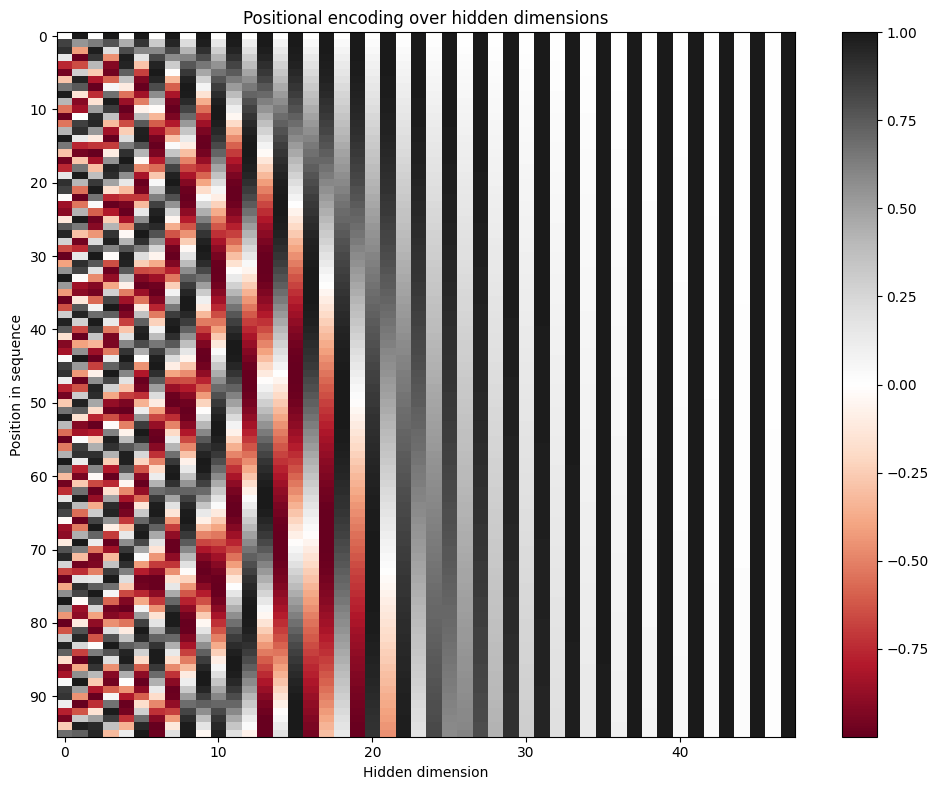

In [26]:
# Relevant plotting imports
import matplotlib.pyplot as plt
plt.set_cmap('RdGy')
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# For our positional encoding visualization, we will ignore the effects of dropout.
encod_block = PositionalEncoding(d_model=48, dropout=0.0, max_len=96)
# We remove the BatchDim from our positional encoding matrix before converting it
# into a NumPy array.
pe = encod_block.pe.squeeze().cpu().numpy()

# Plotting our positional encodings
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))  # Adjusted figure size
pos = ax.imshow(pe, cmap="RdGy", aspect='auto')
fig.colorbar(pos, ax=ax)
ax.set_ylabel("Position in sequence")
ax.set_xlabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_yticks(range(0, 96, 10))
ax.set_xticks(range(0, 48, 10))
plt.tight_layout()
plt.show()
plt.close()

**Low-Level View of Our Positional Encodings:**

In order to get a lower-level appreciation of the inner mechanisms of our positional embeddings, we plot below the sinusoidal waves defining our positional encodings -- specifically, at hidden dimensions 0, 1, 2, and 3.

In observing the below graph, you should notice the following:
1.   The patterns between hidden dimensions 0 & 1 only differ in terms of the starting angle (as a result of $\sin(x)$ versus $\cos(x)$). This pattern extends for hidden dimensions 2 & 3, 4 & 5, etc.
2.   The wavelength for the sinusoidal embeddings increases between hidden dimensions 0 & 1 and hidden dimensions 2 & 3. Naturally, this pattern will extend when looking at hidden dimensions 3 & 4, 5 & 6, etc.

Note that the sinusoidal waves are displayed below as continuous functions instead of discrete matrix entries for visualization purposes.

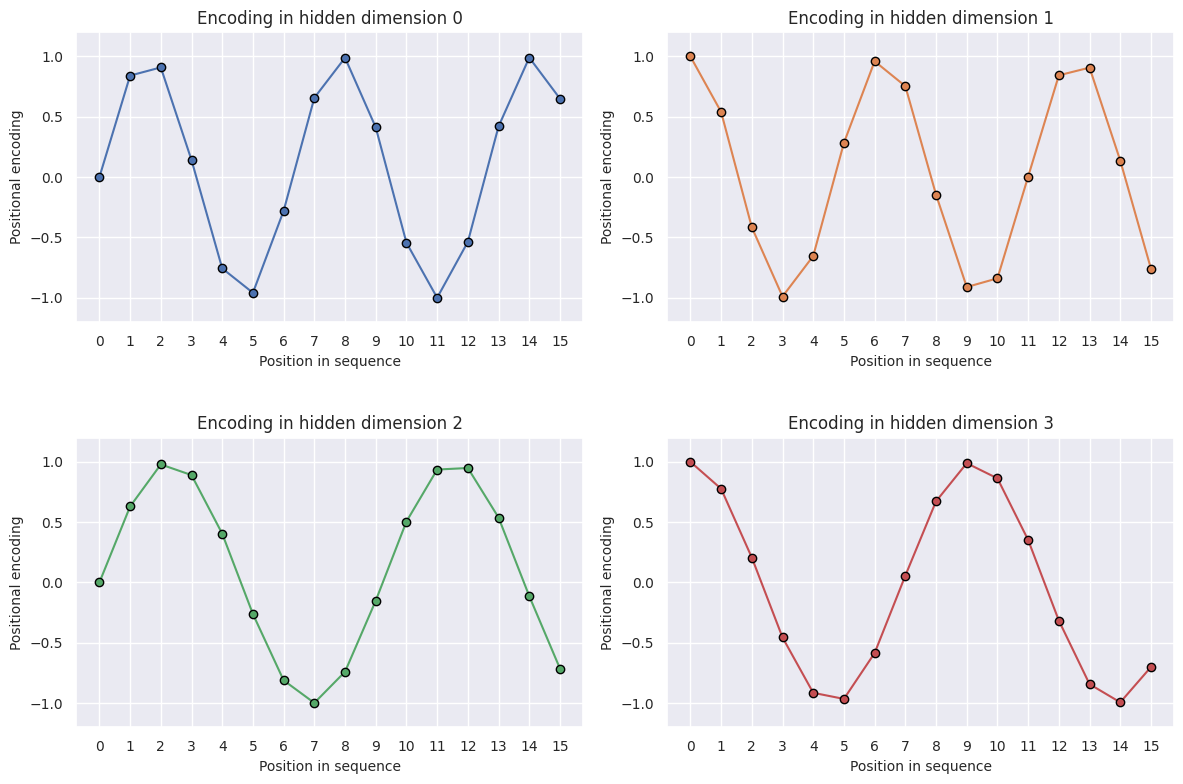

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming we already have our positional encoding matrix 'pe'
# If not, we would need to generate it using the PositionalEncoding class

# Set up the plot style
sns.set_theme()

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the 2x2 grid into a 1D array for easier iteration
ax = ax.flatten()

# Colors for each subplot
colors = ['C0', 'C1', 'C2', 'C3']

for i in range(4):
    # Plot the encoding for the i-th dimension across the first 16 sequence positions
    ax[i].plot(np.arange(16), pe[:16, i], color=colors[i], marker="o",
               markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(0, 16))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)

# Adjust the layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()
plt.close()

#### **5.2.2: Layer norm**

**Introduction:**

Layer Normalization was initially proposed by Lei Ba et al. (2016) in ["Layer Normalization"](https://arxiv.org/abs/1607.06450) as a transformation of the Batch Normalization technique for RNNs. In contrast to Batch Normalization, Layer Normalization is not dependent on the batch size and (as we'll soon see) a more natural application for Transformers, especially when utilized for NLP tasks.

Below, we build out an intuitive and mathematical understanding of Normalization. From there, we look at Layer Normalization through the lens of how it improves upon Batch Normalization, a separate Normalization technique commonly employed in CNNs.

**Intuitive Introduction to Normalization:**

The main motivation for employing normalization in our Transformer (and neural networks in general) is due to issues arising out of the distribution of activations within our neural network. During training, certain neurons' activations may be much larger than others; the activations within a MHA block could end up being much larger in magnitude compared to the activations in our FFNs (see Section 5.2.3), for example. If left un-dealt with when passing on these activations from component to component or layer to layer, these activations can result in exploding gradients when backpropagating through our network. These exploding gradients will slow down our training time, as issues with the pathological curvature of our loss landscape (think of our loss curve as a ravine -- some gradients are now much larger than others) can lead to slower convergence in our SGD algorithm.

To counteract these issues, use normalization in order to restrict the overall distribution of our neuron activations within similar, much more manageable ranges of values. In particular, after being passed through a component of our Transformer, we'll take our transformed input tensor and pool over certain dimensions of that tensor, empirically calculate our mean $\mu_{i}$ and standard deviation $\sigma_{i}$ across each slice $i$ of those pooled dimensions, and then use these values to standardize the activation of each of the elements of our tensor along each slice of those pooled dimensions.

**Mathematical Framework for Normalization:**

Before we get to specific techniques, let's  build out a more rigorous, mathematical framework for Normalization. Let  $z_i$ refer to the $i$'th element of our input tensor. The index $i$ has 3 components, corresponding to batch size, input sequence length, and hidden dimension states: $i=(i_B, i_S,i_H)$. For each element $z_i$, we compute its associated mean and standard deviation using the following equations:

$$\mu_{i} = \frac{1}{|S_i|}\sum_{k \: \in \: S_i}z_k,\;\;
\sigma_{i}=\sqrt{\frac{1}{|S_i|} \sum_{k \: \in \: S_i} (z_k - \mu_{i})^2 + \epsilon}$$

where $S_i$ is the set of elements we average over. For example, if we decided to pool over the input sequence length dimension $i_S$, then $\mathbf{S}$ corresponds to the set of all sets $S_i$ of all elements $z_i$ with matching $i_B$ and $i_H$ values.

Given the appropriate mean and standard deviation, we normalize each element $z_i$ by computing $\hat{z_i}=(z_i - \mu_{i})/\sigma_{i}$, followed by $\mathbf{\hat{z}}=\mathbf{\alpha} \odot \mathbf{\hat{z}} + \mathbf{\beta}$, where we introduce trainable parameters $\mathbf{\alpha}$ and $\mathbf{\beta}$.

Ultimately, whichever Normalization technique we choose to employ, (in most instances) each technique can boil down to choosing which dimensions of our input tensor to pool over (and thus which dimensions to match on) before applying our standardization protocol.

**Batch Normalization & Layer Normalization:**

To compute Batch Normalization, we pool over the batch and sequence length dimensions, matching on the hidden states (thus, $S_i$ corresponds to the set of all elements $z_i$ which match the hidden states index $i_H$ of $i$). While Batch Normalization is a useful Normalization technique for certain architectures (e.g., CNNs), it is not commonly used in Transformers. The reason for this is that during training, we're oftentimes working with small batches of inputs. Naturally, Batch Normalization struggles when the batch size is small, as the empirically-estimated mean and variance parameters may be unreliable due to the small sample size. Furthermore, compensating for this issue by chunking the text into a set of long input sequences can make training longer and more computationally expensive due to activity in the Transformer's attention mechanism.

In order to address these issues, we instead typically employ a Normalization technique called Layer Normalization in our Transformer architecture. In Layer Normalization, we pool only over the hidden states dimension; thus, $S_i$ corresponds to the set of all elements $z_i$ which match both the batch index $i_B$ and sequence length index $i_S$ of $i$. Thus, we no longer have to worry about small batch sizes or input sequence lengths, as long as the size of our hidden state dimensions is sufficiently large.

Note that in some applications of Layer Normalization, we pool over both the hidden states and sequence length dimensions, matching on the batch index $i_B$ of $i$. In a similar vein to how variable input sequence lengths were an issue when constructing our positional encodings, it's not a bad idea to implement the more restrictive version of Layer Normalization if you are concerned about working with small input sequence lengths during training and/or inference.

**Next Steps:**

Below, we construct a $nn.Module$ subclass defining our Layer Normalization as described above. Note that we place a small $\epsilon$ value in our $\hat{z_i}$ computation instead of our $\sigma_{i}$ computation, for more readable code. Subsequently, we'll look at a pseudo-example where we pass in a randomly-generated tensor through our $nn.Module$ subclass in order to better appreciate the effects of Layer Normalization.

In [ ]:
import torch.nn as nn
import torch
import typing

class LayerNorm(nn.Module):
  def __init__(self, feature_size: tuple, eps: float = 1e-6, initialize_parameters : bool = True) -> None:
    '''
    Inputs:
      feature_size - Size of tensor passed to the forward method.
      eps - Small value to prevent division by zero.  Default is 1e-6.
    '''
    super().__init__()
    # We use nn.Parameter() to introduce trainable params α and β into our layer normalization
    self.alpha = nn.Parameter(torch.ones(feature_size))
    self.beta = nn.Parameter(torch.zeros(feature_size))
    self.eps = eps

    if initialize_parameters:
      self._initialize_parameters()

  def _initialize_parameters(self) -> None:
    nn.init.xavier_uniform_(self.alpha)
    nn.init.xavier_uniform_(self.beta)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # In Layer Normalization, we want to normalize over the HiddenDim dimension
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.beta

**Layer Normalization Pseudo-Example:**

Below, we inspect the $state\_dict$ of our $LayerNorm(nn.Module)$ class before passing in a randomly-initialized tensor in order to demonstrate the effects of Layer Normalization. This tensor has a shape of (1, 50, 512); we can think of this tensor as representing a 50-token input sequence with a hidden embedding of size 512 contained in a batch of size 1.

In [ ]:
import numpy as np

print("First, let's look at the state_dict for our LayerNorm module.\n")
x = torch.randn(1,50,512)
layer_norm = LayerNorm(feature_size=tuple(x.size()), initialize_parameters = False)
print(layer_norm.state_dict())

print("\nNow, let's send in an example tensor to see how Layer Normalization works.\n")

print("\033[1mTensor (Before Normalization):\033[0m\n", x)
x = layer_norm.forward(x)
print("\n\033[1mTensor (After Normalization):\033[0m\n", x.data)

x = x.data.squeeze(0)
x_mean, x_std = [], []
for index in range(x.size(0)):
  x_mean.append(x[index,:].mean().tolist())
  x_std.append(x[index,:].std().tolist())

print("\nAs seen across each row in our tensor, we've normalized each layer to have a mean of approximately 0 and a standard deviation of approximately 1.")
print("\n\033[1mAverage Mean Across Sequence Entries:\033[0m", sum(x_mean) / len(x_mean))
print("\n\033[1mAverage Standard Deviation Across Sequence Entries:\033[0m", sum(x_std) / len(x_std))

First, let's look at the state_dict for our LayerNorm module.

OrderedDict([('alpha', tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])), ('beta', tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]))])

Now, let's send in an example tensor to see how Layer Normalization works.

Tensor (Before Normalization):
 tensor([[[-0.4006,  0.5717,  0.5408,  ...,  2.4134,  1.8428,  0.2503],
         [ 0.2151, -1.6778, -1.2399,  ...,  2.4072,  0.6471,  0.0675],
         [ 0.6626, -1.6953,  1.5199,  ...,  0.1976, -0.7204, -1.2891],
         ...,
         [ 0.1237, -0.7375, -0.6886,  ..

#### **5.2.3: Feed forward neural network**

**Introduction:**

At this point, we are nearly ready to start putting everything together and building out the complete transformer architecture. As a final step, we discuss the implementation of Feed-Forward Networks (FFNN or FFN) in our transformer architecture (as well as the final Linear+Softmax layer). If you're curious, take a look at Figure 1 in ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) for a preview of how we're implementing FFNs in the Transformer.

**Why?**

FFNNs give the transformer non-linearity.  As you may have noticed, all components in self attention are linear, so without this non-linear FFNN, we wouldn't be able to model non-linear patterns.  Also , FFNs add more complexity and therefore representational ability.

**Feed-Forward Networks:**

While there are a variety of FFNs, the specific architecture we'll employ here is a fully-connected MLP network. In particular, our FFN will consist of two linear transformations with a ReLU activation (for non-linearity) in between, as such:
$$FFN(x) = Dropout(max(0, xW_{1}+b_{1})W_{2} + b_{2})$$

Where $x$, our input matrix is in $\mathbb{R}^{n \ \times \ d_{model}}$, $W_{1} \in \mathbb{R}^{d_{model} \ \times \ d_{hidden}}$, $W_{2} \in \mathbb{R}^{d_{hidden} \ \times \ d_{model}}$, and $b_1 \in \mathbb{R}^{d_{hidden}}, b_2 \in \mathbb{R}^{d_{model}}$ are bias terms that are added to each row.

- $n$ is the sequence length
- $d_{model}$ is the model dimension
- $d_{hidden}$ is the hidden dimension

And thus, the output is in $\mathbb{R}^{n \ \times \ d_{model}}$, which is what we'd want.

**A Note on Kaiming Initialization:**

Below, you'll notice that we decide to initialize our $nn.Linear$ layers utilizing Kaiming initialization. In short, Kaiming initialization is recommended for $nn.Linear$, $nn.Conv2d$, etc. layers in ReLU-based networks, whereas Xavier initialization is recommended for tanh-based networks -- although such initialization schemes aren't strictly necessary. If you are interested in the mathematical justification behind Kaiming and Xavier initialization, I would recommend checking out [this blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K) by Pierre Ouannes, as well as He et al.'s (2015) original paper on the topic, [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852).

**Next Steps:**

Below we construct a $nn.Module$ subclass defining our FFN as described above before walking through a simple pseudo-example. Subsequently, we'll see how to construct our final Linear+Softmax layer before walking through a more-detailed example.

In [ ]:
import torch.nn as nn
import torch
import typing
from types import SimpleNamespace

class FeedForwardNetwork(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the input (& output!) of the FFN.
      d_ff - Hidden dimensionality of the FFN itself.
      dropout - Dropout probability.
    '''
    super().__init__()
    self.test = nn.Linear(d_model, d_ff)
    self.modules = SimpleNamespace(w_1 = nn.Linear(d_model, d_ff),
                                   w_2 = nn.Linear(d_ff, d_model),
                                   dropout = nn.Dropout(dropout))
    self._init_params()

  # For ReLU-based linear neural networks, it is recommended to use Kaiming initialization (either
  # nn.init.kaiming_normal_ or nn.init.kaiming_uniform_) for the weights.
  def _init_params(self) -> None:
    for module in self.modules.__dict__:
      if isinstance(self.modules.__dict__[module], nn.Linear):
        nn.init.kaiming_normal_(self.modules.__dict__[module].weight, nonlinearity='relu')
        nn.init.zeros_(self.modules.__dict__[module].bias)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.modules.w_2(self.modules.dropout(self.modules.w_1(x).relu()))

# Demonstration
test = torch.randn(1, 50, 512)
ffn = FeedForwardNetwork(512, 2048)
print("\033[1mLet us test out our FFN on a randomly initialized tensor of size (1, 50, 512):\033[0m\n\n", test)
print("\n\033[1mHere's our tensor, once passed through our FFN:\033[0m\n\n", ffn.forward(test).data)

Let us test out our FFN on a randomly initialized tensor of size (1, 50, 512):

 tensor([[[-0.5704, -0.2267,  1.4834,  ..., -0.5831, -0.5785, -0.2904],
         [ 1.5474, -1.1305, -1.1858,  ...,  1.7119, -1.5051, -0.9073],
         [-0.1296,  2.5584, -0.5132,  ...,  1.5866,  0.1940, -1.4766],
         ...,
         [ 0.5601, -0.3927,  1.9492,  ..., -0.9788, -0.4516,  2.8719],
         [-0.2178, -1.0901, -1.9981,  ..., -0.5836, -1.5267, -0.6231],
         [ 1.7181,  0.9160, -0.3032,  ...,  0.5356,  0.7486,  0.8733]]])

Here's our tensor, once passed through our FFN:

 tensor([[[ 0.8686,  0.3764, -0.7811,  ..., -1.4566,  1.5090, -1.7150],
         [ 2.0929,  0.1046, -1.3969,  ..., -0.6677,  2.9669, -0.4942],
         [-1.1804, -0.6651, -0.6096,  ..., -0.9177, -0.3851, -1.1090],
         ...,
         [ 0.1178, -0.0680,  0.0976,  ...,  1.3722, -0.9897, -2.3278],
         [ 0.7521, -0.7276, -1.3304,  ..., -0.7008,  1.0350, -0.1859],
         [-0.3957,  1.1210, -0.6433,  ...,  1.5265,  2.46

**Introduction:**

After passing our inputs through various Multi-Head Attention blocks, Feed-Forward Networks, and Encoder/Decoder layers in general, the final step for our Transformer is to generate our model's output predictions. We discuss the specifics of this process below.

**Linear+Softmax Layer/Output Generator:**

In short, to generate our outputs, we pass our transformed inputs through a final Linear+Softmax layer. This layer does the following: (1) it maps our input's "HiddenDim" dimension ($d_{model}$) to the size of our vocab ($vocab$), and (2) it generates a discrete probability distribution over our vocabulary (from which we can take the argmax over as our prediction, or employ another decision algorithm).

This means that an LLM's final layer output is actually all the possible tokens with a probability next to them.  We then sample a token from the probability distribution.  This behavior is why you'll hear some people say that LLMs are "statistical models" mean that their output is just sampled from some distribution.  We will get more into this later.

Now, in order to complete step (1), we construct a linear projection via $nn.Linear$ (another way to think of this $nn.Linear$ module is as a single-layer, fully-connected FFN). Below, we go with $nn.Linear$'s default PyTorch initialization, although feel free to work with Kaiming or other initialization schemes at this step in your own code. Ignoring the batch dimension, we'll denote the $i$'th row in our transformed tensor as $\mathbf{o}_i$.

In order to complete step (2), we must convert each vector $\mathbf{o}_i$ of logits (of length $vocab$) into probabilities -- that is, we must transform  $\mathbf{o}_i$ such that (a) $0 \le o_{i, v} \le 1$ for every vector entry $o_{i, v}$, and (b) $\sum_{v=1}^{V} o_{i, v} = 1$. Fortunately, we can easily do this with the softmax function, which is defined as follows:
$$softmax(\mathbf{o}_i) \overset{\Delta}{=} \left[\dfrac{e^{o_{i,\ 1}}}{\sum_{v'=1}^{V} e^{o_{i, \ v'}}},...,\dfrac{e^{o_{i,\ V}}}{\sum_{v'=1}^{V} e^{o_{i, \ v'}}}\right]$$
If desired, we could add an additional **temperature** parameter to our softmax function. Temperature is a constant $T$ which we divide every $o_{i, v}$ in our softmax output by. As $T \to 0$, our softmax function approaches the argmax function. By default, $T = 1$.  We can see that having a low temperature will be diving the $o_{i, v}$ by a $T \in (0, 1]$, and will therefore scale $o_{i, v}$ up, but since we're doing softmax, the effect of scaling $o_{i, v}$ becomes exponential, which means that tokens which already had a high probability will get much more of a boost, and so those token's probabilities end up dominating the sample spave more.  Thus $T = 0.00001$ is almost guarenteed to output the same token again and again; we call this behavior *deterministic*.

Whatever particular softmax configuration you choose, just apply softmax to the last dimension of your transformed tensor from step (1) to complete step (2).

**Why Use Log Softmax Instead Of Regular Softmax?**

If you inquire into our particular set-up below, you'll notice we use $nn.functional.log\_softmax$ (which is equivalent to $log(softmax(\mathbf{o}_i)) \: $) in our "step (2)" instead of $nn.functional.softmax$. In short, due to the nature of the logarithm function (namely, it grows slower than linear and exponential functions), Log Softmax is better equipped to handle extreme values in the input data, and thus tends to produce a more stable probability distribution. Additionally, the gradient of the Log Softmax function is both simpler and more numerically stable, increasing computational efficiency in our training.

If you are interested in learning more about this topic, read [this blog post](https://www.baeldung.com/cs/softmax-vs-log-softmax#:~:text=If%20we%20use%20Log%20Softmax,derivative%20of%20the%20Softmax%20function.) by Zhaozhen Xu and Michal Aibin.


**Next Steps:**

Now, we construct a $nn.Module$ subclass defining our Linear+Softmax output layer. Then, we take a look at a brief example where we pass a randomly-generated tensor through a single instance of our FFN and Linear+Softmax layer before doing some final post-processing to generate our predictions.

In [ ]:
import torch.nn as nn
import torch
import typing

class OutputGenerator(nn.Module):
  def __init__(self, d_model: int, vocab: int) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the output of the final FFN.
      vocab - Size of our vocabulary.
    '''
    super().__init__()
    self.projection = nn.Linear(d_model, vocab)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return nn.functional.log_softmax(self.projection(x), dim=-1)

# Demonstration
print("Now, let's imagine we're passing an input through the final stages of our Transformer architecture. \n Here, we'll pass an example tensor of size (1,50,512) through our FFN and our final output generator (we ignore the \"Add & Norm\" step for simplicity).\n We can think of our example tensor as a batch containing a single, 50-token input with an embedding dimension of size 512. Let's state that the size of our vocabulary \n is 100 tokens.\n")
ffn = FeedForwardNetwork(512, 2048)
generator = OutputGenerator(512, 100)
test = torch.randn(1, 50, 512)
ffn.forward(test).data
output = generator.forward(test).data
output = output[:, :(output.size(1) - 1)]
print("Assuming our final token in the sequence we passed in is an [EOS] token, we strip that index from our output as the calculated Log Softmax probabilities are meaningless.\n")
print("\033[1mOutput of our generator:\n\033[0m", "\033[1mSize: \033[0m", tuple(output.size()), "\n\033[1mTensor: \033[0m", output)
print("\nNow, we take the argmax over our Log Softmax probabilities and return the vocabulary index of the most likely token for each sequence entry. Note that in real-life \n applications, we usually take the argmax over our logits instead of our softmax values, for numerical stability reasons.\n")
for index in range(output.size(1)):
  print(f"\033[1mOur prediction for sequence token {index+1}:\033[0m ", output.argmax(dim=-1).squeeze()[index].item())
print("\nIn a real-life example (assuming we've trained our model), most of the predictions produced here would be equivalent to the vocab index \n associated with the subsequent token (assuming we're doing next token prediction).")

Now, let's imagine we're passing an input through the final stages of our Transformer architecture. 
 Here, we'll pass an example tensor of size (1,50,512) through our FFN and our final output generator (we ignore the "Add & Norm" step for simplicity).
 We can think of our example tensor as a batch containing a single, 50-token input with an embedding dimension of size 512. Let's state that the size of our vocabulary 
 is 100 tokens.

Assuming our final token in the sequence we passed in is an [EOS] token, we strip that index from our output as the calculated Log Softmax probabilities are meaningless.

Output of our generator:
 Size:  (1, 49, 100) 
Tensor:  tensor([[[-5.5021, -4.2432, -4.2951,  ..., -5.5019, -4.9849, -5.5031],
         [-4.1487, -3.9786, -5.7291,  ..., -4.3621, -4.1384, -4.0490],
         [-4.6450, -5.1856, -4.0505,  ..., -4.5521, -4.5136, -4.8459],
         ...,
         [-5.6263, -5.0481, -5.9215,  ..., -4.2670, -5.0769, -3.9063],
         [-5.5814, -4.4284, -5.0150,

#### **5.2.4: Additional Components**

Up to this point, we've covered all of the theoretical components necessary for building out a Transformer model. Still, there are some additional components we need to build out code-wise before we can create our Transformer model; as such, we spend Section 5.2.4 addressing these final pieces of the puzzle.

**Introduction:**

First, we need to define a class which can process our input word embeddings. We've discussed word embeddings extensively in previous sections, so we'll instead take the time here to briefly discuss PyTorch's $nn.Embedding$ class.

**PyTorch's Word Embeddings Class:**

As a summary, we can understand word embeddings as a dense encoding of the semantic information of each token in our input sequence that might be relevant to the task at hand; we do not care whether or not semantically similar words (that is, words whose associated embeddings have a high cosine similarity) have similar orthographic representations -- an assumption based upon the theory of [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics).

Instead of manually selecting and constructing various semantic attributes to be included into our word embeddings, we instead typically assume that there are some *latent semantic attributes* inherent within the tokens of our input sequences that our deep learning model can, in principle, learn. In other words, just as we do not manually fix all of the elements of the weight and bias tensor of a $nn.Linear$ layer, we too will leave it up to our Transformer model to learn the proper vector representations of each of our input sequence tokens as stored in a $nn.Embedding$ layer.

As a final note, $nn.Embedding$ stores our word embeddings as a $|V| \times D$ matrix, where $|V|$ is the cardinality (size) of the set representing our vocab $V$, and $D$ is the dimensionality of the embeddings. In particular, our word embeddings matrix is structured such that the word assigned index $i$ has its embedding stored in the $i\text{'th}$ row of the matrix.

**Next Steps:**

Below, we construct $InputEmbeddings$, the class which will handle the word embeddings for all of the tokens of our input sequence(s) to our Transformer. If you would like to look at some simple applied examples of word embeddings, you can reference this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html). Once we construct our Transformer model, our toy example will also make the inner mechanics of $nn.Embedding$ and our $InputEmbeddings$ class clear.

In [ ]:
import torch
import torch.nn as nn

class InputEmbeddings(nn.Module):
  '''
  This class is used to embed your encoder & decoder inputs into the model's hidden dimensionspace using nn.Embedding,
  a simple lookup table that stores embeddings of a fixed dictionary and size.

  For example, if you have a tokenized input sequence length of 50 tokens, you would pass in 'input_size = 50' and
  'd_model = <model hiden dimensionality>' when instantiating this class.
  '''

  def __init__(self, d_model : int, input_size : int) -> None:
    super().__init__()
    self.embedding = nn.Embedding(input_size, d_model)
    self.d_model = d_model

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.embedding(x) * math.sqrt(self.d_model)

**Sublayer Connections:**

The last component we need to build before we can construct our Transformer model is our sublayer connections. Defining a specific class for the sublayer connection isn't strictly necessary; nevertheless, modularizing your projects is a good practice in deep learning and programming in general, and so we decide to modularize our sublayer connection here.

Within both the Encoder and the Decoder of our Transformer architecture (don't worry, we'll introduce what those terms mean soon!), we employ a layer composed of a residual connection followed by layer normalization (commonly referred to as the "Add & Norm" layer) between each subcomponent -- that is, between the various MHA blocks and FFNs composing our Encoder and Decoder. Our $SublayerConnection$ class can be used to initialize and take a forward pass through such a layer.

In [ ]:
import torch
import torch.nn as nn

class SublayerConnection(nn.Module):
  """Residual connection followed by a layer normalization."""

  def __init__(self, feature_size : tuple, dropout : float = 0.0) -> None:
    super().__init__()
    self.layer_norm = LayerNorm(feature_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x : torch.Tensor, sublayer : nn.Module) -> torch.Tensor:
    x = x + self.dropout(sublayer(x))
    x = self.layer_norm(x)
    return x

### **5.2(b): Applications: Putting everything together**

**What is Section 5.2(b)?:**

In short, the purpose of Section 5.2(b) is to build out the Transformer architecture.

Having built out MHA in Section 4.3 and all of the elements of the Transformer in Section 5.2, we are now finally ready to construct our Transformer model. Still, while you are familiar with all of the pieces of the puzzle, you aren't yet familiar with how the all come together; in Sections 5.-6, we walk you through (from a theoretical perspective) precisely this process.

If you are familiar with Transformers, you know there are three major variants: Encoder-only Transformers, Decoder-only Transformers, and Complete (Encoder & Decoder) Transformers. While it's theoretically easiest to walk through each of these three variants separately and sequentially, from an applications perspective, it's much more efficient to build out all of these variants in parallel before introducing some customizability at the end to allow one to choose which variant one wants to initialize.

This is the longer reason why Section 5.2(b) exists. In this section, we modularize our approach to the Transformer and build out the Encoder, the Decoder, and finally the Transformer; taking as inputs the Encoder and Decoder modules, the Transformer module can be configured in order to initialize one of the three major Transformer architecture variants. Finally, we spend Section 5.2(b).3.1 building out a useful function which initializes the Transformer and all of its different puzzle pieces for us.

**Next Steps:**

Unlike with other Sections in this notebook, you aren't supposed to read through this section like a regular textbook chapter. In Sections 5.3-6, you will be periodically introduced to various toy examples highlighting the capabilities of the Transformer architecture. In order to be able to run these examples, you'll be first asked to run all of the code cells in Section 5.2(b) (*even if you don't understand everything yet!*); by the end of Section 5.6, all of the code in Section 5.2(b) will make sense.

In addition to running all of the code in **Section 5.2(b)**, you will also need to run the relevant code cells (i.e. excluding any example code cells) in the following sections:


*   **Section 4.3**
*   **Section 5.2.1**
*   **Section 5.2.2**
*   **Section 5.2.3**
*   **Section 5.2.4**

Now, skip ahead to Section 5.3 to continue reading on.

#### **5.2(b).1: Encoder**

**Introduction:**

In this section, we build the Transformer Encoder. We start by building $EncoderLayer$, a $nn.Module$ subclass which defines a single layer of our Encoder; then, we build out our actual Encoder in $Encoder$.

**Modules Description:**

To instantiate $EncoderLayer$, we need to provide a MHA module, a FFN module, the size of our input feature (of size$\;$[BatchDim, SequenceLen, HiddenDim]), and a $nn.Dropout$ dropout probability. By default, our dropout probability is 0. To make a forward pass through our module, we need to provide an input tensor and an (optional) tensor mask. By default, we utilize no mask.

To instantiate $Encoder$, we need to provide a $EncoderLayer$ module instance and an integer indicating the number of layers we'd like to instantiate in our Encoder. To make a forward pass through our module, we need to provide an input tensor as well as an (optional) tensor mask. By default, we use no mask.

In [ ]:
# Imports
import torch
import torch.nn as nn
import copy
from types import SimpleNamespace
from typing import Optional, Union

# Modules
class EncoderLayer(nn.Module):
    '''This module defines a single layer of the Encoder.'''

    def __init__(self, self_attn : MultiHeadAttention, feed_forward : FeedForwardNetwork, feature_size : tuple, dropout : float = 0.0) -> None:
        '''
        Inputs:
            self_attn - A MHA self-attention module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            feed_forward - A FFN module. This module must be an instance or subclass of FeedForwardNetwork, or must otherwise have the same signature in its dunder __init__ and forward method.
            feature_size - A tuple containing the dimensions of an input tensor.
            dropout - Dropout probability.
        '''
        super().__init__()

        self.modules = SimpleNamespace(self_attn = self_attn,
                                       feed_forward = feed_forward,
                                       sublayers = nn.ModuleList([copy.deepcopy(SublayerConnection(feature_size = feature_size, dropout = dropout)) for _ in range(2)]))

    def forward(self, x : torch.Tensor, mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our encoder layer. You must include an input tensor. Optionally, you can pass in an attention mask.'''
        x = self.modules.sublayers[0].forward(x, lambda x: self.modules.self_attn(x, x, x, mask = mask))
        x = self.modules.sublayers[1].forward(x, lambda x: self.modules.feed_forward(x))
        return x

class Encoder(nn.Module):
    '''This module instantiates the Encoder.'''

    def __init__(self, layer : EncoderLayer, num_layers : int) -> None:
        '''
        Inputs:
            layer - A single instance of an encoder layer. This module must be an instance or subclass of EncoderLayer, or must otherwise have the same signature in its dunder __init__ and forward method.
            num_layers - The number of layers in the encoder.
        '''
        super().__init__()

        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, x : torch.Tensor, mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our encoder. You must include an input tensor. Optionally, you can include an attention mask.'''
        for layer in self.layers:
            x = layer(x = x, mask = mask)
        return x

#### **5.2(b).2: Decoder**

**Introduction:**

In this section, we build the Transformer Decoder. We start by building $DecoderLayer$, a $nn.Module$ subclass which defines a single layer of our Decoder; then, we build out our actual Decoder in $Decoder$.

**Modules Description:**

To instantiate $DecoderLayer$, we need to provide a MHA module for the Decoder's self-attention mechanism, a MHA module for the Decoder's decoder-encoder attention mechanism, a FFN module, a tuple representing the size of our input features (of size$\;$[BatchDim, SequenceLen, HiddenDim]), and a $nn.Dropout$ dropout probability. By default, we use a dropout probability of 0. To make a forward pass through our module, we need to provide an input tensor, the tensor output of the Encoder block, the mask utilized for the Encoder input, and a mask to be used for the Decoder input. By default, there is neither an Encoder nor Decoder mask.

To instantiate $Decoder$, we need to provide an instance of the $DecoderLayer$ module and an integer specifying the number of layers we'd like to instantiate our $Decoder$ module with. To make a forward pass through our module, we need to provide an input tensor, the tensor output of the Encoder block, the mask utilized for the Encoder input, and a mask to be used for the Decoder input. By default, there is neither an Encoder nor Decoder mask.

In [ ]:
# Imports
import torch
import torch.nn
import copy
from types import SimpleNamespace
from typing import Optional, Union

# Modules
class DecoderLayer(nn.Module):
    '''This module defines a single layer of the Decoder.'''

    def __init__(self, self_attn : MultiHeadAttention, encoder_attn : MultiHeadAttention, feed_forward : FeedForwardNetwork, feature_size : tuple, dropout : float = 0.0) -> None:
        '''
        Inputs:
            self_attn - A MHA self-attention module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            encoder_attn - A MHA module which takes as query and value the outputs of the Encoder. With the exception of the optional mask, this module should be configured in the exact same manner as the self_attn module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            feed_forward - A FFN module. This module must be an instance or subclass of FeedForwardNetwork, or must otherwise have the same signature in its dunder __init__ and forward method.
            feature_size - A tuple containing the dimensions of an input tensor.
            dropout - Dropout probability.
        '''
        super().__init__()

        self.modules = SimpleNamespace(self_attn = self_attn,
                                       encoder_attn = encoder_attn,
                                       feed_forward = feed_forward,
                                       sublayers = nn.ModuleList([copy.deepcopy(SublayerConnection(feature_size = feature_size, dropout = dropout)) for _ in range(3)]))

    def forward(self, x : torch.Tensor, encoder_output : torch.Tensor, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our decoder layer. You must input an input tensor as well as the output of the encoder (encoder_output). Optionally, you can provide a mask for the self_attn module and a mask for the encoder_attn module.'''
        x = self.modules.sublayers[0].forward(x, lambda x: self.modules.self_attn(x, x, x, mask = decoder_mask))

        # If you are using a decoder-only model, then set encoder_output equivalent to x.
        x = self.modules.sublayers[1].forward(x, lambda x: self.modules.encoder_attn(x, encoder_output, encoder_output, mask = decoder_mask))

        x = self.modules.sublayers[2].forward(x, lambda x: self.modules.feed_forward(x))
        return x

class Decoder(nn.Module):
    '''This module instantiates the Decoder.'''

    def __init__(self, layer : DecoderLayer, num_layers : int) -> None:
        '''
        Inputs:
            layer - A single instance of a decoder layer. This module must be an instance or subclass of DecoderLayer, or must otherwise have the same signature in its dunder __init__ and forward method.
            num_layers - The number of layers in the decoder.
        '''
        super().__init__()

        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, x : torch.Tensor, encoder_output: torch.Tensor, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our decoder. You must input an input tensor as well as the output of the encoder (encoder_output). Optionally, you can provide a mask for the self_attn module and a mask for the encoder_attn module.'''
        for layer in self.layers:
            x = layer(x, encoder_output, encoder_mask, decoder_mask)
        return x

#### **5.2(b).3: Transformer**

**Introduction:**

In this section, we build $Transformer$, a $nn.Module$ subclass which can be used to instantiate and make a forward pass through a Transformer.

**Module Description:**

To instantiate our $Transformer$ module, we need to provide an instance of $Encoder$, an instance of $Decoder$, an instance of $nn.Sequential$ containing instances of our $InputEmbeddings$ and $PositionalEncoding$ classes for both our Encoder and Decoder, an instance of $OutputGenerator$, and a string specifying which of the three Transformer variants we would like to instantiate: "encoder", "decoder", "encoder-decoder".

To make a forward pass through our module, you will need to provide different inputs based upon the particular Transformer variant you've initialized:
*   $\textbf{Encoder-Only}$: You need to provide an input tensor to the Encoder as well as an (optional) Encoder mask.
*   $\textbf{Decoder-Only}$: You need to provide an input tensor to the Decoder as well as an (optional) Encoder mask. If you want to provide as input the output of an Encoder (or the output of an Encoder-like module) and do not want to instantiate a complete Encoder-Decoder Transformer, you can also provide as input the the output tensor of an Encoder as well as an (optional) Encoder mask. Make sure that the Encoder output tensor has already been embedded into the $Transformer$'s hidden dimensionspace.
*   $\textbf{Encoder & Decoder}$: You need to provide an input tensor to the Encoder, an input tensor to the Decoder, and finally (optional) Encoder and (optional) Decoder masks.

By default, all of the signature arguments in $Transformer$'s forward method are set to None, so you only need to specify as arguments the relevant inputs mentioned above.

In [ ]:
# Imports
import torch
import torch.nn as nn
from typing import Union

# Module
class Transformer(nn.Module):
  '''This module can be used to instantiate and make a forward pass through a Transformer.'''

  def __init__(self, encoder : Encoder, decoder : Decoder, encoder_embed : nn.Sequential, decoder_embed : nn.Sequential, output_generator : OutputGenerator, model_construct : Union[str("encoder"), str("decoder"), str("encoder-decoder")]) -> None:
    '''
    Inputs:
      encoder - This is an instance of the Encoder class. Make sure to initialize this class with all of the required parameters.
      decoder - This is an instance of the Decoder class. Make sure to initialize this class with all of the required parameters.
      encoder_embed - This is an instance of the nn.Sequential class whose inputs are instances of the InputEmbeddings and PositionalEncoding classes. Make sure to initialize this class with all of the required parameters.
      decoder_embed - This is an instance of the nn.Sequential class whose inputs are instances of the InputEmbeddings and PositionalEncoding classes. Make sure to initialize this class with all of the required parameters.
      output_generator - This is an instance of the OutputGenerator class. Make sure to initialize this class with all of the required parameters.
      model_construct - Pass in an argument specifying what instance of the Transformer you would like to return: encoder-only, decoder-only, or the complete encoder-decoder model. See the signature to this method for the list of acceptable inputs.
    '''
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.encoder_embed = encoder_embed
    self.decoder_embed = decoder_embed
    self.output_generator = output_generator
    self.model_construct = str(model_construct)

  def forward(self, encoder_input : torch.Tensor = None, encoder_output : torch.Tensor = None, decoder_input : torch.Tensor = None, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
    '''
    Inputs:
      encoder_input - This is the input sequence passed to the encoder. This method maps the hidden dimensionality of the input to the embed_dim; otherwise, you must make sure tokenization has been completed, alongside any other required pre-processing methods.
      encoder_output - This is the output of the encoder, passed into the second MHA block within the Decoder. If you are using a decoder-only model, simply leave this argument as None.
      decoder_input - This is the input sequence passed to the decoder. This method maps the hidden dimensionality of the input to the embed_dim; otherwise, you must make sure tokenization has been completed, alongside any other required pre-processing methods.
      encoder_mask - An optional input. Pass in a tensor mask for your input to the encoder.
      decoder_mask - An optional input. Pass in a tensor mask for your input to the decoder.
    '''
    if self.model_construct == "encoder":
      return self.encoder(self.encoder_embed(encoder_input), encoder_mask)
    elif self.model_construct == "decoder":
      if encoder_output is not None:
        return self.decoder(self.decoder_embed(decoder_input), encoder_output, encoder_mask, decoder_mask)
      else:
        return self.decoder(self.decoder_embed(decoder_input), self.decoder_embed(decoder_input), encoder_mask, decoder_mask)
    elif self.model_construct == "encoder-decoder":
      return self.decoder(self.decoder_embed(decoder_input), self.encoder(self.encoder_embed(encoder_input), encoder_mask), encoder_mask, decoder_mask)
    else:
      print("This is an invalid input.")

##### **5.2(b).3.1: Transformer initialization function**

**A Useful Function:**

While not strictly necessary, I've written a useful function below which can be quickly used to initialize the $Transformer$ class. Detailed descriptions of all of the relevant inputs are provided in a docstring below, so I won't bother belaboring the point.

This function works perfectly well for all of the toy examples you'll see later on in Section 5. If you decide to create examples of your own from the $Transformer$ module (toy or not), you may find yourself using a modified version of the below function.

In [ ]:
# Imports
import copy

# Function
def model_constructor(model_construct : Union[str("encoder"), str("decoder"), str("encoder-decoder")], feature_size : tuple, encoder_input_size : int, decoder_input_size : int, vocab_size : int, num_layers : int, embed_dim : int = 512, d_ff : int = 2048, num_heads : int = 8, dropout : float = 0.1, pos_encoding_max_length : int = 5000):
  '''
  This function can be used to initialize the Transformer module.

  Inputs:
    model_construct - Pass in an argument specifying what instance of the Transformer you would like to return: encoder-only, decoder-only, or the complete encoder-decoder model. See the signature to this method for the list of acceptable inputs.
    feature_size - A tuple containing the dimensions of an input tensor.
    encoder_input_size - The size of the vocabulary of the input sequence passed to the encoder. For example, an input sequence of 10 randomly generated integers ranging from 0 to 100 would correspond to a vocabulary size of 101.
    decoder_input_size - The size of the vocabulary of the input sequence passed to the decoder.
    vocab_size - The number of labels you have in your vocabulary for your output generator.
    num_layers - The number of layers in your Transformer. If you initialize a Transformer with both an encoder and a decoder, both blocks will have the same number of layers.
    embed_dim - The size of the hidden dimensions of the input(s) to the model.
    d_ff - The size of the hidden dimensionas of the feed forward network.
    num_heads - The number of heads in the MHA blocks. Make sure that embed_dim % num_heads == 0.
    dropout - Dropout probability.
    pos_encoding_max_length - The maximum length of the positional encoding.
  '''

  positional_encoding = PositionalEncoding(embed_dim, dropout, pos_encoding_max_length)
  multihead_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
  ffn = FeedForwardNetwork(embed_dim, d_ff, dropout)
  output_generator = OutputGenerator(embed_dim, vocab_size)

  encoder = Encoder(layer = EncoderLayer(copy.deepcopy(multihead_attn), copy.deepcopy(ffn), feature_size, dropout), num_layers = num_layers)
  decoder = Decoder(layer = DecoderLayer(copy.deepcopy(multihead_attn), copy.deepcopy(multihead_attn), copy.deepcopy(ffn), feature_size, dropout), num_layers = num_layers)
  encoder_embed = nn.Sequential(InputEmbeddings(embed_dim, encoder_input_size), copy.deepcopy(positional_encoding))
  decoder_embed = nn.Sequential(InputEmbeddings(embed_dim, decoder_input_size), copy.deepcopy(positional_encoding))

  model = Transformer(
      encoder,
      decoder,
      encoder_embed,
      decoder_embed,
      copy.deepcopy(output_generator),
      model_construct
  )

  return model

### **5.3: The encoder**

An encoder and decoder are different types of transformers; to complicate things a little, the original "transformer" was comprised on an encoder and a decoder.  So you might have to pay attention to context, since "transformer" can be an encoder, decoder, or both.  For that reason, we'll only use the "t-word" when absolutely necessary.


For sequence length $n$ and embedding dimension $d_{model}$, the encoder's purpose is to generate a matrix $\in \mathbb{R}^{n \, \times \, d_{model}}$ that ***encodes*** contextual information about the input sequence.

The obvious question is then "but don't we already have an n by model dimension matrix" from our input embeddings?  Why do we need an encoder?

There are a couple differences between the embedding matrix and the encoder's matrix.  In short, the embedding matrix doesn't contain useful information about sequence level relationships.  The embedding matrix looks at each word in isolation and generates an embedding as such, while the encoder's output is meant to contains token level relationships as they relate to the prompt.

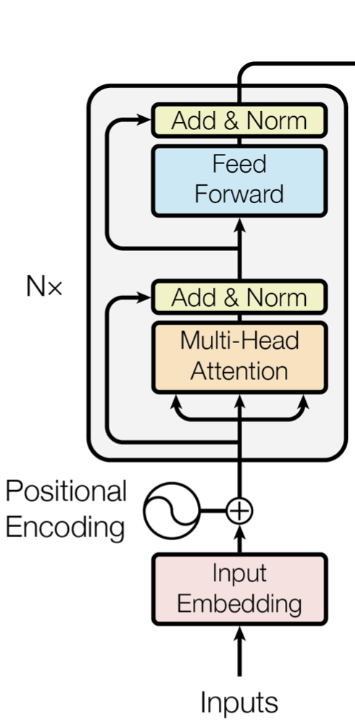

Let's now talk about the architecture of an encoder.  We have our positional encoding to our input embeddings (5.2.1) which give us a positionally aware embeddings.  This is our input to the encoder.

The three arrows into the MHA block represent the keys, queries, and values matricies that we use to calculate attention.

We the peform multi head attention (section 4) to try to understand the relationships between our tokens and capture their "meaning".

Once we've calculated an MHA matrix of the same dimension of the input, we add that matrix with our input matrix and normalize those values to keep gradients well-behaved (section 5.2.2).

Then, we put that though the FFNN (5.2.3) which allows non-linear relationships, add the output to our input, and finish by normalizing it all for backprop's sake.

**Toy Example:**

Below, we highlight a toy example involving use of an Encoder-only Transformer. In this example, we are tasking a Transformer Encoder with reversing a sequence of random integers fed to the model as input. In particular, we will be feeding our model with a single batch with 15 tokens of hidden dimension 1; these 15 tokens are pulled from a set of 10 randomly integers ranging from 0 to 9.

Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense. Before reading onwards, it is recommended that you review the following sections: [Section 5.2(b).1](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=tg9sYxEWmB2P), [Section 5.2(b).3](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=YmaBesKVmOTU), and [Section 5.2(b).3.1](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=3KpvJdcwmWHF). When you're ready, take your time reading through the below code, and feel free to tweak any of the parameters or inputs.

In [ ]:
# Imports
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy



# Dataset class
class Dataset(data.Dataset):
  def __init__(self, num_different_numbers : int, seq_len : int, batch_size : int) -> None:
    '''
    Inputs:
      num_different_numbers - We will be using torch.randint in order to generate our batch of sequences of random numbers. The low by default is 0. The highest possible integer generated is the value assigned to this variable.
      seq_len - The length of each sequence of random integers.
      batch_size - This determines the size of the batch of the sequence of random integers.
    '''

    super().__init__()
    self.parameters = SimpleNamespace(num_different_numbers = num_different_numbers,
                                      seq_len = seq_len,
                                      batch_size = batch_size)

    self.data = torch.randint(self.parameters.num_different_numbers, size=(self.parameters.batch_size, self.parameters.seq_len))

  # To define our Dataset class, we'll need to define two methods: __len__ and __getitem__.
  # __len__ returns the size of the dataset.
  def __len__(self) -> torch.Tensor.size:
    return self.size

  # __getitem__ returns the idx'th batch entry.

  # IMPORTANT: Our Dataset class is currently constructed such that it only produces a single batch. If we want to have a dataset which can handle multiple
  # batches, we'd need to (a) pass in an num_batches parameter to the __init__ method, and (b) pass in an additional batch_idx parameter to this method.
  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    input_data = self.data[idx]
    labels = torch.flip(input_data, dims=(0,))
    return input_data, labels



# This small function can be used to instantiate our Dataset class with the desired initialization configuration described above.
def initialize_data():
  temp_dataset = partial(Dataset, num_different_numbers = 10, seq_len = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



# We'll call this function to return our model prediction, among other values.
def inference():
  '''
  Outputs:
    encoder_input - This is the input sequence passed to the encoder. In our case, this is a single batch containing 15 tokens.
    labels - This is the label sequence corresponding to the input sequence. In our case, this is simply a flipped version of the encoder_input.
    model_prediction - These are the predictions for our model. If trained, our model should be able to predict the labels from the encoder_input.
    loss - This is our model's cross entropy loss.
    accuracy - This is our model's accuracy (between 0 and 1).
  '''

  # Instantiate our model. One quirk of the model_constructor function is that we need to specify 'decoder_input_size', even though this information isn't relevant if we are using the encoder-only implementation of the Transformer.
  test_model = model_constructor(model_construct = "encoder", feature_size = (1, 15, 1), encoder_input_size = 10, decoder_input_size = 0, vocab_size = 10, num_layers = 2)
  # Putting our model into evaluation mode (instead of training mode)
  test_model.eval()

  data = initialize_data()
  labels = data[0][1]
  encoder_input = data[0][0].unsqueeze(0)

  # To store our predictions, we're going to instantiate here a tensor of size (1,1) containing the input 0.
  model_prediction = torch.empty(1, 1).fill_(0)
  # We're going to store all of our model's output probabilities into this empty tensor.
  probabilities_reference = torch.empty(15, 10).requires_grad_(False)

  for i in range(15):
    encoder_output = test_model(encoder_input = encoder_input)
    probabilities = test_model.output_generator(encoder_output[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_integer = torch.max(probabilities, dim = 1)
    # Assume that our next predicted integer is 6. This step converts next_integer from tensor([6]) to tensor(6), which is necessary for concatenating all of our predictions together into a single tensor.
    next_integer = next_integer[0]
    if i == 0:          # For our first prediction, we want to replace the 0 input in the model_prediction tensor.
      model_prediction[:, 0] = next_integer
    else:         # Following our first prediction, we want to concatenate our predictions to the model_prediction tensor.
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_integer)], dim = 1).type_as(labels)

  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return encoder_input, labels, model_prediction, loss, accuracy


# Outputs
results = inference()
print("\033[1mThis is the input to our Transformer:\033[0m ", results[0].data)
print("\n\033[1mThese are the labels for our input:\033[0m ", results[1].data)
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", results[2].data)
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[3].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[4].data)

This is the input to our Transformer:  tensor([[8, 2, 4, 6, 4, 8, 4, 9, 1, 1, 8, 6, 9, 5, 6]])

These are the labels for our input:  tensor([6, 5, 9, 6, 8, 1, 1, 9, 4, 8, 4, 6, 4, 2, 8])

This is our model's (untrained) prediction:  tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])

This is our model's cross entropy loss:  tensor(2.2924)

This is our model's accuracy:  tensor(0.2000)


Perhaps the most notable encoder is BERT (bidirectional encoder representations from transformers), which was the base for many NLP tasks (summerization, sentiment analysis, etc.) pre Open AI's GPT 3.

### **5.4: The decoder**

#### **5.4.1: A characterization of our favorite LLMs**

Many of the poplar models right now (GPT series, Llama, Mistral, etc.) are decoder-only models, which mean that they are just a lot of decoders lined up one after the other.  What do the decoders do?  They predict the next token.

That's it.

From the provided text, all it does is pick the next token.  Then once it predicts that token, using all the previous text, it will predict the next one.  It will predict this behavior until it predicts some kind of specialized stop token.

For example, if it takes in the prompt:

> <|begin_of_text|>Write a haiku about a cat lounging in the sun<|end_of_text|>

It might give you something like:

> <|begin_of_text|> The

then

> <|begin_of_text|>Cat

then

> <|begin_of_text|>Cat basks


And it might reach:

> <|begin_of_text|>Cat basks in the sun\
He licks his paws now and then\
Mischief is tiring

and finish it off with:

> <|begin_of_text|>Cat basks in the sun\
He licks his paws now and then\
Mischief is tiring<|end_of_text|>

Right when it ouputs the <|end_of_text|> (which doesn't get shown to us, the user), it knows it's job is done.

Thus, LLMs are simply just auto-regressive next word predictors.  It never goes back on it's text, it just outputs the next word

But how does it choose the next word?  Recall our discussion in section 5.2.3: in a decoder, the final attention layer's output (called **logits** - yes, it's important to know this word) is a vector of dimension vocab size.

In our vocab size, each token has a unique index.  At each token's position is a raw score that our many layers of attention have calculated.  We then take a softmax over that whole vector, and we're left with a vector who's components sum to one.

Now, we can inperperet the remaining number in the position of each token as a probability that the token will be selected as the next token.

In more formal language, we have a discrete distribution of token probabilities.  We then sample the distribution to choose our next token.

Keep in mind that with a vocab size in the thousands, all but a few tokens will have negligable probabilities after we apply softmax.  There are a few hyperparameters that we can pass the LM to alter the distribution, like temperature (see 5.2.3), top_p, top_k, and others.  We will cover those later.

And so, LLMs are considered statistical, auto-regressive next word predictors.  There are plenty of debates about what this architecture implies for the nature of LLM, but we'll let you come to your own conclusions here.

#### **5.4.2: Decoder architecture**

Now that we understand what the LMs are actually doing, let's look at the architecture, which may look familiar:
(credit: https://www.ericjwang.com/2023/01/22/transformers.html)

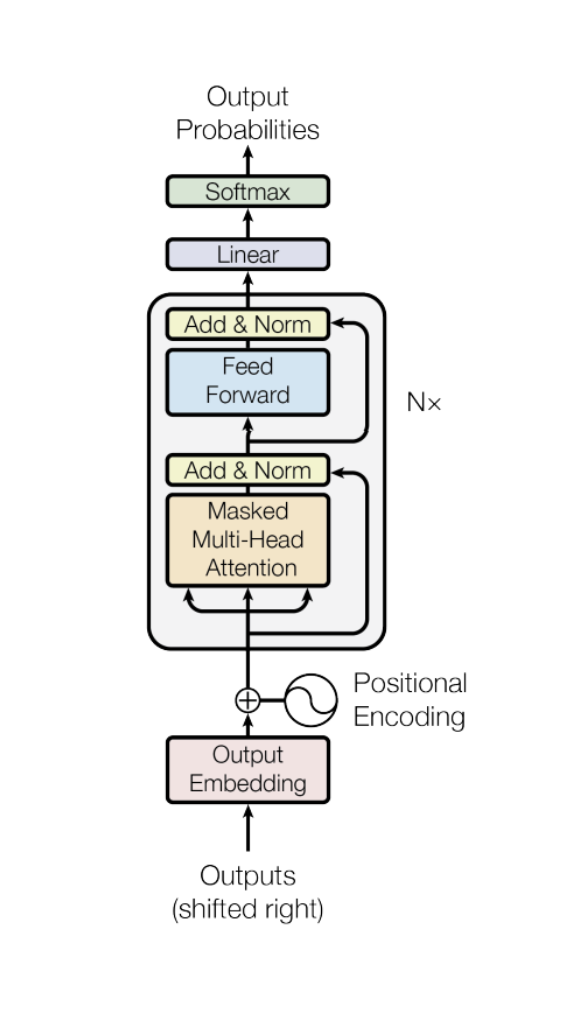

You can see that the main differences between the encoder and the decoder are the outputs being "shifted right", the word "masked" in the attention head, and the "linear" and "softmax" layer at the end.

Let's go over those!

The main idea of the decoder is that it won't have access to tokens which come after it, which is synonymous with saying that it's "autoregressive".  Thus, the attention mechanism can only pay attention to itself and the tokens which preceed if it to predict the next word.

We can think of this arrangement as an upper triangular matrix, which we will call a mask:

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Masked Multi-Head Attention Matrix</title>
    <style>
        table {
            border-collapse: collapse;
        }
        td, th {
            width: 50px;
            height: 40px;
            text-align: center;
            border: 1px solid black;
        }
        .accessible {
            background-color: #cce5ff;
        }
        .masked {
            background-color: #f8d7da;
        }
        .header {
            background-color: #f0f0f0;
            font-weight: bold;
        }
    </style>
</head>
<body>
    <h3>Masked Multi-Head Attention Matrix (Upper Triangular)</h3>
    <table>
        <tr>
            <th class="header"></th>
            <th class="header">the</th>
            <th class="header">cat</th>
            <th class="header">sat</th>
            <th class="header">right</th>
            <th class="header">there</th>
        </tr>
        <tr>
            <th class="header">the</th>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">cat</th>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">sat</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">right</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">there</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
        </tr>
    </table>
</body>
</html>

As we can see, each column only has access to itself and it's prior tokens, demarcated by the '1' where we have access.

In the wild, real matricies of auto-regressive models like this one will have this shape naturally since we won't know the next token until we output it.


To make an LLM effective, we put it through a process called "pre-training" where we give tons of natural language data and have it do next token prediction on all of it.

We need to be a bit more careful with masked attention during pre-training.  We don't want our LM to have any access to the token it's trying to predict, nor the tokens after it.

To circumvent this issue, we add in a start token, like [SOS] (start of sentence), \<start\>, or \<begin\> that firstly lets the LLM know that the generation is happening, and secondly to make the attention matrix that predicts token $i$ (indexed from 1) in $\mathbb{R}^{i \ × \ i}$ while not including the token itself.


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Shifted Right Decoder Input Embeddings</title>
    <style>
        table {
            border-collapse: collapse;
            margin-bottom: 20px;
        }
        td, th {
            width: 50px;
            height: 40px;
            text-align: center;
            border: 1px solid black;
        }
        .accessible {
            background-color: #cce5ff; /* Light blue for accessible cells */
        }
        .masked {
            background-color: #f8d7da; /* Light red for masked cells */
        }
        .header {
            background-color: #f0f0f0; /* Grey for headers */
            font-weight: bold;
        }
        .start {
            background-color: #d4edda; /* Light green for start token */
        }
    </style>
</head>
<body>
    <h3>Shifted Right Decoder Input Embeddings</h3>
    <p>The shifted right sequence introduces a start token at the beginning of the input.</p>
    <table>
        <tr>
            <th class="header"></th>
            <th class="header">Start</th>
            <th class="header">the</th>
            <th class="header">cat</th>
            <th class="header">sat</th>
            <th class="header">right</th>
        </tr>
        <tr>
            <th class="header">Start</th>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">the</th>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">cat</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">sat</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
            <td class="accessible">1</td>
        </tr>
        <tr>
            <th class="header">right</th>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="masked">0</td>
            <td class="accessible">1</td>
        </tr>
    </table>
</body>
</html>

In this example, we see that "there" has been cut off, so our attention matrix is only amongst seen tokens.

In practice, your prompt will be a part of that matrix too, becasue, of course, the LM has to pay attention to your prompt.

Lastly, the linear (FFNN) and the softmax layer come at the end of $N$ decoders (the notation $N$ comes from the above decoder picture).  Here, with all the masked self-attention calculated, we project our output to a vector of vocab size.

Does this sound familiar?  We covered this process in 5.2.3, but I'll copy paste it here if you don't remember or didn't read that section.

>In short, to generate our outputs, we pass our transformed inputs through a final Linear+Softmax layer. This layer does the following: (1) it maps our input's "HiddenDim" dimension ($d_{model}$) to the size of our vocab ($vocab$), and (2) it generates a discrete probability distribution over our vocabulary (from which we can take the argmax over as our prediction, or employ another decision algorithm).

> This means that an LLM's final layer output is actually all the possible tokens with a probability next to them.  We then sample a token from the probability distribution.  This behavior is why you'll hear some people say that LLMs are "statistical models" mean that their output is just sampled from some distribution.  We will get more into this later.

> Now, in order to complete step (1), we construct a linear projection via $nn.Linear$ (another way to think of this $nn.Linear$ module is as a single-layer, fully-connected FFN). Below, we go with $nn.Linear$'s default PyTorch initialization, although feel free to work with Kaiming or other initialization schemes at this step in your own code. Ignoring the batch dimension, we'll denote the $i$'th row in our transformed tensor as $\mathbf{o}_i$.

> In order to complete step (2), we must convert each vector $\mathbf{o}_i$ of logits (of length $vocab$) into probabilities -- that is, we must transform  $\mathbf{o}_i$ such that (a) $0 \le o_{i, v} \le 1$ for every vector entry $o_{i, v}$, and (b) $\sum_{v=1}^{V} o_{i, v} = 1$. Fortunately, we can easily do this with the softmax function, which is defined as follows:
$$softmax(\mathbf{o}_i) \overset{\Delta}{=} \left[\dfrac{e^{o_{i,\ 1}}}{\sum_{v'=1}^{V} e^{o_{i, \ v'}}},...,\dfrac{e^{o_{i,\ V}}}{\sum_{v'=1}^{V} e^{o_{i, \ v'}}}\right]$$

> If desired, we could add an additional **temperature** parameter to our softmax function. Temperature is a constant $T$ which we divide every $o_{i, v}$ in our softmax output by. As $T \to 0$, our softmax function approaches the argmax function. By default, $T = 1$.  We can see that having a low temperature will be diving the $o_{i, v}$ by a $T \in (0, 1]$, and will therefore scale $o_{i, v}$ up, but since we're doing softmax, the effect of scaling $o_{i, v}$ becomes exponential, which means that tokens which already had a high probability will get much more of a boost, and so those token's probabilities end up dominating the sample spave more.  Thus $T = 0.00001$ is almost guarenteed to output the same token again and again; we call this behavior **deterministic**.

> Whatever particular softmax configuration you choose, just apply softmax to the last dimension of your transformed tensor from step (1) to complete step (2).

So it's actually the *decoder* that spits out probabilities for each token, and since that's all large language models do, that why all our favorite LLMs are decoder only.  

The encoder creates interesting semantic representations of the word using numbers, but for LLMs, we only need to generate, which is the decoder's job.

**Toy Example:**

Here, we highlight a toy example involving the utilization of a Decoder-only Transformer. In this example, we are tasking a Transformer Decoder with predicting a sequence of Fibonacci numbers. The Transformer is tasked with generating n Fibonacci sequence entries, starting from the i'th entry; the first token in our masked input will correspond to the integer i. In particular, we will be asking our Transformer to generate a single batch of 15 Fibonacci sequence entries, starting from the 10th entry.

Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense. Before reading onwards, it is recommended that you review the following sections: [Section 5.2(b).2](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=EMi5ErDXmKBm), [Section 5.2(b).3](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=YmaBesKVmOTU), and [Section 5.2(b).3.1](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=3KpvJdcwmWHF). When you're ready, take your time reading through the below code, and feel free to tweak any of the parameters or inputs.

In [ ]:
# Imports
import torch
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy



# Function to generate a Fibonacci number
def fibonacci_sequence(fibonacci_num):
  '''Function to generate the fibonacci_num'th Fibonacci sequence entry.'''
  if fibonacci_num < 2:
    return int(fibonacci_num)
  else:
    return fibonacci_sequence(fibonacci_num - 1) + fibonacci_sequence(fibonacci_num - 2)



# Dataset class
class Dataset(data.Dataset):
  def __init__(self, fibonacci_start : int, num_fibonacci_numbers : int, batch_size : int) -> None:
    '''
    Inputs:
      fibonacci_start - The i'th Fibonacci sequence entry. For example, fibonacci_start = 10 corresponds to the 10th Fibonacci sequence entry: 55.
      num_fibonacci_numbers - The number of Fibonacci sequence entries to generate, starting from fibonacci_start.
      batch_size - The number of input sequences to generate (that is, the size of a single batch).
    '''
    super().__init__()

    # The first token in our input sequence will be an integer indicating the first Fibonacci sequence entry to generate.
    self.starting_token = torch.empty(1,1).fill_(fibonacci_start)
    self.fibonacci_numbers = torch.LongTensor([fibonacci_sequence(fibonacci_start + i) for i in range(num_fibonacci_numbers)])

    self.data = torch.cat([self.starting_token, self.fibonacci_numbers.unsqueeze(0)], dim=1).type_as(self.fibonacci_numbers)

  def __len__(self) -> torch.Tensor.size:
    return self.size

  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    input_data = self.data[idx][:-1]
    labels = self.data[idx][1:]
    return input_data, labels



# Function to initialize our data
def initialize_data():
  temp_dataset = partial(Dataset, fibonacci_start = 10, num_fibonacci_numbers = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



def inference():
  # The size of our vocabulary must be large enough to have indices for all of the integers from 0 to the largest Fibonacci number we generate.
  max_fibonacci_start = 10
  max_num_fibonacci_numbers = 15
  vocab_size = fibonacci_sequence(max_fibonacci_start + max_num_fibonacci_numbers - 1) + 1

  # One quirk of the model_constructor function is that we need to specify 'encoder_input_size', even though this information isn't relevant if we are using the decoder-only implementation of the Transformer.
  test_model = model_constructor("decoder", feature_size = (1, 15, 1), encoder_input_size = 0, decoder_input_size = vocab_size, vocab_size = vocab_size, num_layers = 2)
  test_model.eval()

  # Initialize data
  data = initialize_data()
  labels = data[0][1]
  decoder_inputs = data[0][0].unsqueeze(0)
  decoder_mask = MaskingMechanism.decoder_mask(size = 15)

  # Tensors used to store our model predictions and probabilities
  model_prediction = torch.empty(1, 1).fill_(0)
  probabilities_reference = torch.empty(15, vocab_size).requires_grad_(False)

  # Inference loop
  for i in range(15):
    decoder_output = test_model(decoder_input = decoder_inputs, decoder_mask = decoder_mask)
    probabilities = test_model.output_generator(decoder_output[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_fibonacci = torch.max(probabilities, dim = 1)
    next_fibonacci = next_fibonacci[0]

    if i == 0:
      model_prediction[:, 0] = next_fibonacci
    else:
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_fibonacci)], dim = 1).type_as(labels)

  # Metric calculations
  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return decoder_inputs, labels, model_prediction, loss, accuracy



# Output
results = inference()
print("\033[1mThis is the input to our Transformer:\033[0m ", f"\n{results[0].data}")
print("\n\033[1mThese are the labels for our input:\033[0m ", f"\n{results[1].data}")
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", f"\n{results[2].data}")
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[3].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[4].data)

This is the input to our Transformer:  
tensor([[   10,    55,    89,   144,   233,   377,   610,   987,  1597,  2584,
          4181,  6765, 10946, 17711, 28657]])

These are the labels for our input:  
tensor([   55,    89,   144,   233,   377,   610,   987,  1597,  2584,  4181,
         6765, 10946, 17711, 28657, 46368])

This is our model's (untrained) prediction:  
tensor([[39889, 39889, 39889, 39889, 39889, 28902, 39889, 39889, 39889, 39889,
         39889, 39889, 39889, 13206, 39889]])

This is our model's cross entropy loss:  tensor(10.6781)

This is our model's accuracy:  tensor(0.)


The first ever proposed transformer, however, is the encoder-decoder architecture, which uses the encoder to give an interesting representation to the decoder to generate.  Though the encoder-decoder has fallen out of favor for now, since it's classic and not too much work given what you already know, we'll give it a shot.

### **5.5: The Encoder-Decoder**

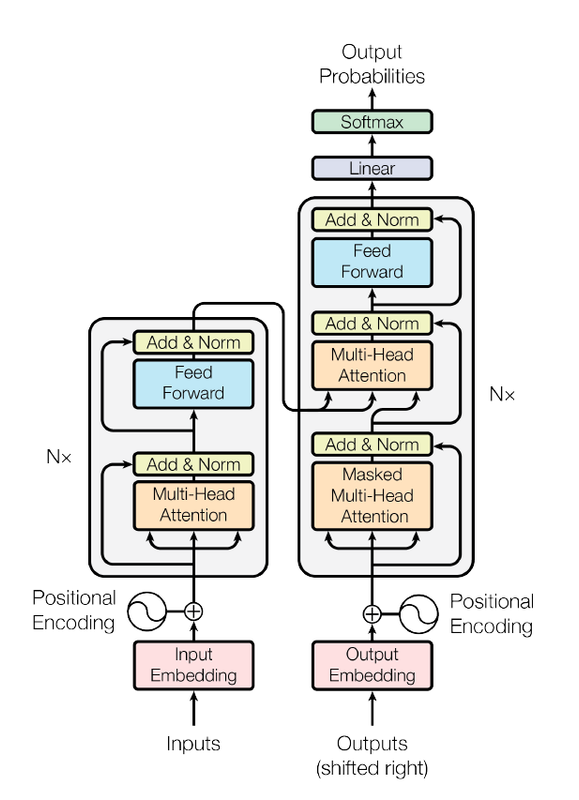

The change here is that extra multi-head attention layer in the decoder that has arrorws coming from the encoder.

What's happening here is that the encoder's reprentational ability is being used to act as the key and value matrix in the decoder's second MHA head.  We get the queries matrix from   All the other attributes remain the same.

I know I said I'd stay away from the "t-word", but this image was used in the original "Attention is All You Need" paper by Vaswani et al., the paper that invented the transformer archicecture.  It will go on to likely be one of the most iconic images in all of AI if it isn't already.

"Attention is All You Need" is pretty difficult to understand if you don't know already what they're talking about, and even then, it tends to be light on certain details perhaps becasue they assumed the reader would already be familiar with most of the concepts.

Nevertheless, I suggest you give reading it a crack or two.

**Toy Example:**

Here, we highlight a toy example involving the use of a complete Encoder & Decoder Transformer. In this example, we are tasking a Transformer with a simple language task: Integers-to-Binary language translation. We will be feeding a set of randomly-generated integers (a single batch of 15 tokens ranging in value from 0 to 10) to our encoder before tasking our decoder with translating these integers into their respective binary representation.

Note that Integers-to-Binary language translation is a formal language translation task (a much simpler task compared to natural language processing, or NLP).

Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense. Before reading onwards, it is recommended that you review the following sections: [Section 5.2(b).3](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=YmaBesKVmOTU) and [Section 5.2(b).3.1](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=3KpvJdcwmWHF). When you're ready, take your time reading through the below code, and feel free to tweak any of the parameters or inputs.

In [ ]:
## Toy Encoder-Decoder Example
# Description
'''
In this example, we are tasking a complete Transformer model with a simple language task: Integers-to-Binary language
translation. We will be feeding a set of randomly generated integers to our encoder before tasking our decoder with
translating these integers into their binary representation.
'''

# Imports
import torch
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy

# Integers-to-Binary Translation Function
def int_to_binary(num):
  '''Given an integer, this function returns its binary representation. We use [2:] to remove the '0b' prefix.'''
  return bin(num)[2:]



# Dataset Class
class Dataset(data.Dataset):
  def __init__(self, vocab : int, num_random_integers : int, batch_size : int) -> None:
    super().__init__()
    self.data = torch.randint(vocab, size=(batch_size, num_random_integers))

  def __len__(self) -> torch.Tensor.size:
    return self.size

  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    encoder_input = self.data[idx]

    # We append a [CLS] 0-token to the start of the decoder_input. This [CLS] token tells our Decoder to predict the
    # binary representation of the first integer in the sequence we've passed to the Encoder.
    decoder_input = torch.cat([torch.empty(1).fill_(0), torch.LongTensor([int(int_to_binary(input)) for input in encoder_input[:-1]])], dim = 0)

    labels = torch.LongTensor([int(int_to_binary(input)) for input in encoder_input])
    return encoder_input, decoder_input, labels



# Data initialization function.
def initialize_data():
  temp_dataset = partial(Dataset, vocab = 11, num_random_integers = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



# Inference function
def inference():
  # The binary representation of the integer 10 is '1010'; as such, we need a Decoder and Output Generator vocabulary which can represent all integers from 0 to 1010.
  test_model = model_constructor("encoder-decoder", feature_size = (1,15,1), encoder_input_size = 11, decoder_input_size = 1011, vocab_size = 1011, num_layers = 2)
  test_model.eval()

  data = initialize_data()
  labels = data[0][2]
  encoder_input = data[0][0].unsqueeze(0)
  decoder_input = data[0][1].unsqueeze(0).type_as(encoder_input)
  decoder_mask = MaskingMechanism.decoder_mask(size = 15)

  model_prediction = torch.empty(1, 1).fill_(0)
  probabilities_reference = torch.empty(15, 1011).requires_grad_(False)

  # Inference loop
  for i in range(15):
    transformer_ouput = test_model(encoder_input = encoder_input, decoder_input = decoder_input, decoder_mask = decoder_mask)
    probabilities = test_model.output_generator(transformer_ouput[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_binary = torch.max(probabilities, dim = 1)
    next_binary = next_binary[0]
    if i == 0:
      model_prediction[:, 0] = next_binary
    else:
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_binary)], dim = 1).type_as(labels)

  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return encoder_input, decoder_input, labels, model_prediction, loss, accuracy



# Outputs
results = inference()
print("\033[1mThis is the Encoder input to our Transformer:\033[0m ", f"\n{results[0].data}")
print("\033[1mThis is the Decoder input to our Transformer:\033[0m ", f"\n{results[1].data}")
print("\n\033[1mThese are the labels for our input:\033[0m ", f"\n{results[2].data}")
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", f"\n{results[3].data}")
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[4].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[5].data)

This is the Encoder input to our Transformer:  
tensor([[9, 0, 1, 7, 5, 0, 1, 0, 6, 5, 1, 4, 6, 6, 9]])
This is the Decoder input to our Transformer:  
tensor([[   0, 1001,    0,    1,  111,  101,    0,    1,    0,  110,  101,    1,
          100,  110,  110]])

These are the labels for our input:  
tensor([1001,    0,    1,  111,  101,    0,    1,    0,  110,  101,    1,  100,
         110,  110, 1001])

This is our model's (untrained) prediction:  
tensor([[527, 262, 527, 878, 948, 948, 527, 622, 527, 262, 948, 214, 527, 527,
         527]])

This is our model's cross entropy loss:  tensor(6.9155)

This is our model's accuracy:  tensor(0.)


The encoder-decoder was gradually phased out in favor of the decoder-only because it has less weights and are more parallelizable, since the docder blocks don't have to wait for the encoder representation.

Since decoders can do what encoder-decoders can as well, why double the number of parameters and sacrifice scaling?

The idea of having infrastructure the can scale brings us to the next section:


### **5.6: Why transformers?**

Now that you've spent a lot of time learning about transformers, you might have noticed that we never stopped to ask ourselves: what makes transformers so popular?

Simply, transformers were the first natural language mode that could scale to longer sequences.  No architecture before it had all the good traits of transformers simultaneously:


*   Parallelizable: we can process entire sequences at once
*   Scalable:  the more compute and size we throw on a transformer, the more its performance increases, which is actually not the case for many models
*   Size agnostic:  transformers can take in sequences of any size (within reason), which more traditional models couldn't do
*   Attention: attention is great becasue it models contextual relationships across the sequence, and isn't just limited to it's neighbhors

With those in mind, the transformer is not infallible.

Remember that for an input sequence of length *n*, key matrix $$K \in \mathbb{R}^{n \times d_{\text{model}}}$$ and query matrix $Q \in \mathbb{R}^{n \times d_{\text{model}}}$, the matrix product of $QK^T$ has dimensions $\mathbb{R}^{n \times n}$, which means that there are $n^2$ values in this product. Because of this, we say that **attention scales quadratically**. So we can't just have an arbitrarily long sequence, since the computational cost of attention can explode.

Thankfully, there are solutions that involve modifying the way attention is calculated that result in a more linear cost of sequence length.

Some of these methods include:

*   Sliding window attention (https://arxiv.org/abs/1901.02860)
*   Sparse attention (https://arxiv.org/abs/1904.10509)
*   RoPE (https://arxiv.org/abs/2104.09864)


Lastly, I'll touch on GPUs.  GPUs are a graphics card found in many gaming PCs.  If you know anything about graphics, then you might know that it involves a lot of matrix calculations in parallel.  

GPUs' ability to performs many operations in parallel has always made it a cornerstone in ML, especailly NVIDIA's GPUs, which have a computing platform called CUDA (Compute United Device Architecture), which allows for greater control of the computation.

As a side, note, CUDA is standard with almost all ML code; it also just so happens that CUDA is native to NVIDIA, meaning that other GPU manufacturers like AMD can't just use CUDA with their GPUs.  CUDA has essentially led NVIDIA to coner the marker for ML, which lead to a massive market boom for NVIDIA in 2024.

Also contributing to NVIDIA's boom were transformer scaling laws.  Since transformers scale so well, the more compute you can throw at a LLM, the bigger you can allow your model to be, implying better performance and longer sequence lengths.  Resultingly, AI companies have scrambled to get as many NVIDIA GPUs as possible.

NVIDIA has from a graphics card company catering towards gamers to leading the AI revolution.



## **Section 6: Introduction to 🤗**

In [ ]:
# Initial Imports
!pip install --quiet datasets evaluate transformers[sentencepiece]
!pip install --quiet zstandard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 25.7 MB/s eta 0:00:00


As the title suggests, Section 6 presents a rigorous introduction to the 🤗 ecosystem; in particular, we will provide readers with a strong foundation in 3 major HF libraries: 🤗 Datasets, 🤗 Tokenizers, and 🤗 Transformers.

If you already have experience with 🤗, you may find yourself skimming portions of this section. Note that besides covering the practical applications of the 🤗 system, we also cover certain theoretical components of the HF architecture (e.g. memory-mapped files with Apache Arrow data formatting) and LLM architecture in general (e.g. WordPiece, one prominent tokenization algorithm).

### **6.1: 🤗 Datasets**

$\textbf{Section Introduction:}$

In this section, we will cover basic functionality with 🤗 Datasets. In particular, we will look at some of the prominent practical applications of the HF Datasets library when it comes to loading in and working with Dataset & DatasetDict objects before turning towards a theoretical discussion of memory-mapping files with Apache Arrows (memory save) and streaming in datasets (disk space save).

#### **6.1.1: Loading local and remote datasets**

$\textbf{Introduction:}$

In order to load in locally-stored and remotely-stored datasets into our HF ecosystem, we will use the HF Datasets' `load_dataset()` function.

You can read a detailed documentation of this function [here](https://huggingface.co/docs/datasets/v2.21.0/en/package_reference/loading_methods#datasets.load_dataset). In short, the 2 main arguments which this function takes are:

1.   `path`: We use this argument to specify the type of loading script we want to use. The main options are: CSV & TSV ("csv"), text files ("text"), JSON & JSON Lines ("json"), and pickled DataFrames ("pandas").
2.   `data_files`: This argument specifies the path to one or more files.

Additionally, another common argument you might be working with is the `field` argument. For example, if you're working with a nested JSON object such as the following:

<pre><code class="python">{"version": "0.1.0",
   "data": [{"a": 1, "b": 2.0, "c": "foo", "d": false},
          {"a": 4, "b": -5.5, "c": null, "d": true}]
}
</code></pre>

then you'd want to specify `field = "data"` when loading in the above JSON object as a dataset.

Below, we have a table listing all of the common data formats which `load_dataset()` supports:

\

\begin{array}{ccc}
  \textbf{Data format} & \textbf{Loading script} & \textbf{Example} \\
  \hline
  CSV \; \& \; TSV & \small{"csv"} & \scriptsize{load\_dataset("csv", \; data\_files="my\_file.csv")} \\
  \hline
  Text \; files & \small{"text"} & \scriptsize{load\_dataset("text", \; data\_files="my\_file.txt")} \\
  \hline
  JSON \; \& \; JSON \ Lines & \small{"json"} & \scriptsize{load\_dataset("json", \; data\_files="my\_file.jsonl")} \\
  \hline
  Pickled \; DataFrames & \small{"pandas"} & \scriptsize{load\_dataset("pandas", \; data\_files="my\_dataframe.pkl")}
\end{array}

$\textbf{Example:}$

As a simple example for working with local and remote datasets, we'll be working with the [SQuAD-it dataset](https://github.com/crux82/squad-it/), a large-scale dataset for QA in Italian.

In [ ]:
# Let's load in the SQuAD-it training and test splits locally using a simple wget command

!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

--2024-09-11 04:29:47--  https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz [following]
--2024-09-11 04:29:47--  https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7725286 (7.4M) [application/octet-stream]
Saving to: ‘SQuAD_it-train.json.gz’

SQuAD_it-train.json 100%[===================>]   7.37M  --.-KB/s    in 0.09s   

2024-09-11 04:29:47 (78.6 MB/s) - ‘SQuAD_it-train.json.gz’ saved [7725286/7725286]

--202

In [ ]:
from datasets import load_dataset

# HF Datasets can automatically decompress GZIP, ZIP, TAR, and other files of a similar format.
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
  # You can also pass in a list of files. If you do so, by default HF will try to combine all the files into a single split,
  # which is by default "train".

  # Additionally, you can glob files that match a specified pattern according to the rules used by the Unix shell.
    # Example: ' data_files="*.json" ' will glob all the JSON files in a directory as a single split.


# Loading in our dataset
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

# Final result
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

As we see, our loaded-in dataset is a `DatasetDict` object, with our specified "train" and "test" splits. A `DatasetDict` object is an object with split names (e.g. "train", "test") as keys and `Dataset` objects as values. The main advantage of `DatasetDict` objects is that we can use dataset transform methods (Section 6.1.2), like map or filter, to process all the splits at once.

In the HF ecosystem, the `Dataset` object is a base class backed by an Arrow table (Section 6.1.3).

In [ ]:
# With our DatasetDict object, we can easily do some basic indexing using a format similar to that employed by the
# pandas library.

# Third example in our test split
squad_it_dataset["test"][2]

{'title': "ABC (Stati Uniti d'America)",
 'paragraphs': [{'context': "L' American Broadcasting Company (ABC) (stlized nel suo logo come abc dal 1957) è una rete televisiva commerciale americana trasmissione televisiva che è di proprietà del Disney-ABC Television Group, una controllata della divisione Disney Media Networks di The Walt Disney Company. La rete fa parte delle grandi reti televisive Big Three. La rete ha sede a Columbus Avenue e West 66th Street a Manhattan, con ulteriori uffici e stabilimenti di produzione a New York City, Los Angeles e Burbank, California.",
   'qas': [{'answers': [{'answer_start': 257,
       'text': 'The Walt Disney Company'},
      {'answer_start': 171, 'text': 'Disney-ABC Television Group'},
      {'answer_start': 171, 'text': 'Disney-ABC Television Group'}],
     'id': '57267b755951b619008f7433',
     'question': "Quale società possiede l' American Broadcasting Company?"},
    {'answers': [{'answer_start': 74, 'text': '1957'},
      {'answer_start': 

In [ ]:
# We can load in this same dataset remotely, using an HTTPS (or other desired) protocol.

url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

# Final result
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

#### **6.1.2: Basic Functionality: Dataset.map(), Dataset.filter(), and more**

$\textbf{Introduction:}$

In this section, we'll be working with the **Drug Review Dataset** that's hosted on the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) to demonstrate some important HF Datasets functions and methods. This dataset contains patient reviews on various drugs, along with the condition being treated and a 10-star rating of the patient’s satisfaction.

In [ ]:
# Loading in & unzipping our dataset
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

In [ ]:
# Instantiating our dataset
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")
  # TSV is just a variant of CSV that uses tabs instead of commas as the separator.
  # In Python, \t is the tab character.

In [ ]:
# Let's grab a small, random sample of our dataset.
sample = drug_dataset["train"].shuffle(seed = 42).select(range(1000))
  # The Dataset.shuffle() method randomly shuffles the dataset.

  # The Dataset.select() method expects an iterable of indices. Here, we use range(1000) to take the first 1000
  # examples of our shuffled dataset.

# Fraction of our sample
sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

Right now, one may notice the following:


---


>1.   The `Unnamed: 0` column is possibly an anonymized ID for each patient; if so, we'd like to rename this column with a more descriptiv\e name.
2.   Our `condition` column contains a mixture of uppercase and lowercase labels which we'd like to normalize.
3.   The entries of our `review` colum are all of various lenghts; additionally, some contain HTML character codes (e.g., `&\#039;`), which we'd like to strip.

---

Let's now address each of these issues using some basic HF Datasets functionality.

$\textbf{Issue 1:}$

In [ ]:
## Issue 1

# Testing our patient ID hypothesis
# The Dataset.unique() function can be used to verify that the number of IDs matches the number of rows in each split.
for split in drug_dataset.keys():
  assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

# Calling the Dataset.rename_column() function to rename "Unnamed: 0" to a more descriptive title.
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

# Final result
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In order to address Issue 2, we need to introduce two new functions: `Dataset.filter()` and `Dataset.map()`.

`Dataset.filter()` allows one to apply a filter function to all the elements in a Dataset's Arrow table (individually or in batches), updating the table to only include examples which when applied to the filter function return `True`. You can read more about the function in its documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.filter).

`Dataset.map()` is a more general function which allows one to apply a function to all examples in a Dataset's Arrow table (individually or in batches), updating the table. If our function returns a column that already exists, this function will override this column's values. You can read more about the function in its documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.map).

We'll discuss using `batched = True` soon, but for now we assume that we are only feeding in individual inputs into the above two functions. As such, the functions we pass in as arguments to these functions should only expect a single example.

$\textbf{Issue 2:}$

In [ ]:
## Issue 2

# First, we use Dataset.filter() to filter out any examples whose entires to the "condition" column are None
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

# Now, we use Dataset.map() to normalize our "condition" column by lowercasing every entry
drug_dataset = drug_dataset.map(lambda x: {"condition": x["condition"].lower()})

# Let's check if our functions worked
drug_dataset["train"]["condition"][:3]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['left ventricular dysfunction', 'adhd', 'birth control']

Before moving on to Issue 3, let's check the lengths of each of the entries in our "review" column to get a better appreciation of the variety of different reviews we are working with.

`Dataset.map()` is a smart function in that when our input function returns a dictionary whose key does not correspond to one of the column names in the dataset, `Dataset.map()` will automatically create a new column corresponding to this new key.

---

*Note: An alternative way to add a new column to each of our Dataset splits would be to use the `Dataset.add_column()` function. You can read this function's documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.add_column).*

In [ ]:
# We use splitting on whitespace as a rough indicator of the length of each of our reviews
drug_dataset = drug_dataset.map(lambda x: {"review_length": len(x["review"].split())})

# Now, let's use Dataset.sort() to sort the entries in our dataset by the values stored in our newly created
# column. The first couple of entries in our sorted Dataset will contain the shortest reviews.

# Here, we'll just take a look at the training split.
drug_dataset["train"].sort("review_length")[:3]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

$\textbf{Issue 3:}$

In [ ]:
## Issue 3

# First, let's filter out all examples which contain fewer than 30 words. Such reviews won't be sufficiently informative
# if we're trying to build a language model that can predict somebody's condition based upon a provided review.
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)

# Now, we use Dataset.map() to unescape (i.e. remove) all the HTML characters in our corpus.
import html

earlier_drug_dataset = drug_dataset # For later purposes

drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

Now, we're about halfway through Section 6.1.2. The last few topics we need to cover are as follows:

---

>1.   Increasing the peformance of `Dataset.map` using `batched = True`.
2.   Converting `Dataset` objects to `pandas.DataFrame` objects and back.
3.   Saving a dataset.

---

Let's now get to these agenda items.

$\textbf{(1) Batched Functionality with Dataset.map()}$

If we pass in `batched = True`, our `Dataset.map()` function will pass in a batch of examples to the map function all at once (the batch size is configurable but defaults to 1,000). In particular, our map function will receive a dictionary whose keys are fields of our dataset and whose values are lists of values (of the same length as our specified batch size).

For example, we could've speeded up the process of unescaping all of our HTML characters back in **Issue 3** by using:

<pre><code class="python">drug_dataset = drug_dataset.map(
  lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched=True
  )
</code></pre>

We can further speed up the performance of `Dataset.map()` using multiprocessing. In order to enable multiprocessing, pass in an integer value specifying the number of processes to use to the `num_proc` argument.

To truly appreciate the power of these computational speed-ups, let's time our `Dataset.map()` function applied to different copies of an earlier version of `drug_dataset` using various different configurations.


In [ ]:
import copy
from datasets import load_dataset
import html

earlier_drug_dataset_1, earlier_drug_dataset_2, earlier_drug_dataset_3 = copy.deepcopy(earlier_drug_dataset), copy.deepcopy(earlier_drug_dataset), copy.deepcopy(earlier_drug_dataset)

# Timing our Dataset.map() function with various different computational speed-ups implemented.
%time earlier_drug_dataset_1 = earlier_drug_dataset_1.map(lambda x: {"review": html.unescape(x["review"])})

%time earlier_drug_dataset_2 = earlier_drug_dataset_2.map(lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched = True)

%time earlier_drug_dataset_3 = earlier_drug_dataset_3.map(lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched = True, num_proc = 4)

As we see above, deploying `Dataset.map()` utilizing `batched` and/or `num_proc` has results in significant time-saves. In our case, using a single process ended up being faster in comparison to multiprocessing (likely due to the introduced communication overhead); for more complicated mapping functions, though, `num_proc` can prove to be a significant time-saver.

$\textbf{(2) Converting Datasets to DataFrames & Back}$

To enable the conversion between various third-party libraries, HF Datasets provides a `Datasets.set_format()` function. This function changes only the *output format* of the dataset -- the underlying *data format* is still Apache Arrow. Under the hood, `Datasets.set_format()` does this by changing the return format for the dataset's `__getitem__()` dunder method.

Let's quickly see this put into practice.

In [ ]:
# Changing the output format of our dataset to a pandas DataFrame
drug_dataset.set_format("pandas")

# Initializing a DataFrame instance of the training split of our drug_dataset
train_df = drug_dataset["train"][:]
  # Notice that we take a (complete) slice of drug_dataset["train"]. This is because the data format of
  # drug_dataset["train"] is still a Dataset object, whereas a slice of drug_dataset["train"] (which renders a
  # particular ouput format for drug_dataset["train"]) is a DataFrame object.

train_df.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
3,35696,Buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
4,155963,Cialis,benign prostatic hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43,68


We can also convert a pandas DataFrame to a HF Datasets Dataset object.

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
    num_rows: 138514
})

Finally, we can reset the output format of `drug_dataset` from `"pandas"` back to `"arrow"`.

In [ ]:
drug_dataset.reset_format()

$\textbf{(3) Saving Our Dataset}$

There's a lot more functionality to explore as it pertains to HF Datasets (some of which we'll see in Section 6.4). For now though, let's be satisfied with what we've covered so far & move on to saving our processed dataset.

HF automatically caches every downloaded dataset and the operations performed on it; to save a dataset to your disk, though, you'll need to manually do so.

HF Datasets provides three main functions to save your dataset in different formats.

\begin{array}{cc}
  \textbf{Data format} & \textbf{Function} \\
  \hline
  \small{Arrow} & \scriptsize{Dataset.save\_to\_disk()} \\
  \small{CSV} & \scriptsize{Dataset.to\_csv()} \\
  \small{JSON} & \scriptsize{Dataset.to\_json()}
\end{array}

Using the `Arrow` format, you can store your entire dataset into a single directory. In particular, this directory will contain a $\;$ *dataset_dict.json* $\;$ followed by a subdirectory for each split of your Dataset (in our case, a *train* and *test* split). Each split subdirectory contains its own $\;$ *dataset.arrow* $\;$ table, as well as some metadata in $\;$ *dataset_info.json* $\;$ and $\;$ *state.json* $\;$ (and possibly some additional files).

Another advantage of the `Arrow` format is that you can easily load your dataset back in. For example, when saving this dataset you did something like the following:

<pre><code class="python">drug_dataset.save_to_disk("drug-reviews")
</code></pre>

you can easily load the dataset back in using `load_from_disk()`:

<pre><code class="python">drug_dataset_reloaded = load_from_disk("drug-reviews")
</code></pre>

For the `CSV` and `JSON` formats, you'll need to store each split as a separate file. For example, you could save each `Dataset` in your `DatasetDict` object into separate `JSONL` files utilizing something like the following command:

<pre><code class="python">for split, dataset in drug_dataset_clean.items():
  dataset.to_json(f"drug-reviews-{split}.jsonl")
</code></pre>

To subsequently load in these files, use the techniques discussed in Section 6.1.1.

---

*Note: By default, datasets are cached at `/.cache/huggingface/datasets`. You can change this location by setting the `HF_DATASETS_CACHE` environment variable to another directory path, such as follows:*

<pre><code class="python">os.environ["HF_DATASETS_CACHE"] = "/path/to/another/directory/datasets"
</code></pre>

#### **6.1.3: Apache Arrow and memory-mapped files**

$\textbf{Introduction:}$

Before getting into an explanation of memory-mapping and the Arrow file format, let's first practically understand its RAM benefits with **The Pile**.

From the [HF NLP Course](https://huggingface.co/learn/nlp-course/chapter5/4?fw=pt#what-is-the-pile):

>"The Pile is an English text corpus that was created by EleutherAI for training large-scale language models. It includes a diverse range of datasets, spanning scientific articles, GitHub code repositories, and filtered web text. The training corpus is available in 14 GB chunks, and you can also download several of the individual components."

For our demonstration, we're going to be looking at the PubMed Abstracts dataset, a corpus of abstracts from 15 million biomedical publications on PubMed. This dataset is in a `JSON Lines` format and has been compressed using the `zstandard` library.

In [ ]:
from datasets import load_dataset

# Load in dataset
data_files = "https://huggingface.co/datasets/casinca/PUBMED_title_abstracts_2019_baseline/resolve/main/PUBMED_title_abstracts_2019_baseline.jsonl.zst"
pubmed_dataset = load_dataset("json", data_files=data_files, split="train")

# See our results
pubmed_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)_title_abstracts_2019_baseline.jsonl.zst:   0%|          | 0.00/6.86G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

Dataset({
    features: ['meta', 'text'],
    num_rows: 15518009
})

With 15,518,009 rows of data, we can already tell that this is a pretty large dataset. To get a better appreciation of the size of the dataset we're working with, let's measure the size of the dataset on our disk space. We can do so by accessing the `dataset_size` attribute, which measures the size of our dataset in bytes.



In [ ]:
# Size of our dataset (in bytes)
print(f"\033[1mNumber of files in dataset :\033[0m {pubmed_dataset.dataset_size}")

# Size of our dataset (in gigabytes)
size_gb = pubmed_dataset.dataset_size / (1024**3)
print(f"\033[1mDataset size (cache file) :\033[0m {size_gb:.2f} GB")

Number of files in dataset : 20978892555
Dataset size (cache file) : 19.54 GB


As we can see, our dataset is nearly takes up nearly **20 GB** on our disk space. Now, let's check up how much RAM we're utilizing in order to load & access this dataset. For a point of reference, if we were loading this dataset in using `pandas`, we should expect according to Wes Kinney’s famous [rule of thumb](https://wesmckinney.com/blog/apache-arrow-pandas-internals/) that we'd be using 5 to 10 times as much RAM as the size of our dataset (i.e., **100 - 200 GB** of RAM).

One way to measure memory usage in Python is through the `psutil` library, which we'll install here.

In [ ]:
!pip install psutil

Using `psutil`, we can check the memory usage of our current process through the `Process()` class. In particular, we'll be looking at the memory profile of the `rss` attribute, or *resident set size*. RSS measures the fraction of memory that a process occupies in RAM. This measurement also includes the memory used by the Python interpreter, any libraries we’ve loaded, and a variety of other processes, so the actual amount of memory used to load the dataset is likely a bit smaller.

In [ ]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"\033[1mRAM used:\033[0m {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 720.29 MB


In contrast to our expectations, we find that we've been able to load and access our dataset with ***significantly less RAM as compared to the actual size of our dataset.***

Now, let's get into the reasons why HF Datasets is allowing us to make such significant saves on memory usage.

$\textbf{Apache Arrow & The Arrow Data Format}$

As detailed [here](https://arrow.apache.org/overview/), the Arrow data format is a standardized, language-agnostic [in-memory](https://en.wikipedia.org/wiki/In-memory_database) columnar format for representing structured, table-like datasets in-memory. This data format also comes with a rich data type system, including nested and user-defined data types. Let's break down some of these terms.

**Columnar Formatting:**

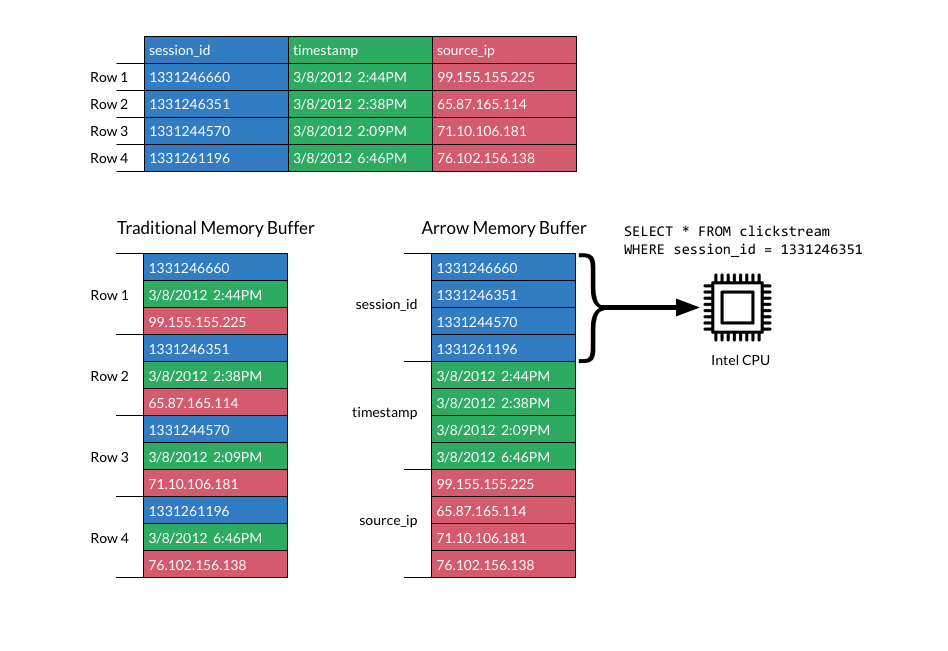

[Columnar format](https://www.microsoft.com/en-us/research/publication/columnar-storage-formats/#:~:text=The%20columnar%20data%20formats%20are,the%20particular%20query%20or%20workload.) is a data storage format that organizes data by column instead of row. As opposed to row-oriented storage, columnar storage can significantly reduce the amount of data fetched from disk by allowing access to only the columns that are relevant for the particular query or workload. With further efficient encoding and compression techniques, the columnar format can drastically reduce storage requirements without sacrificing query performance.

The columnar format also enables [vectorization](https://www.intel.com/content/www/us/en/developer/articles/technical/vectorization-a-key-tool-to-improve-performance-on-modern-cpus.html#:~:text=Vectorization%20is%20the%20process%20of,to%20multiple%20data%20(SIMD).) using the latest SIMD ([Single Instruction, Multiple Data](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data)) operations included in modern processors. In other words, the columnar format is one of many reasons we're able to use `batched = True` in our `Dataset.map()` function, for example.

**Standardization & Arrow Libraries:**

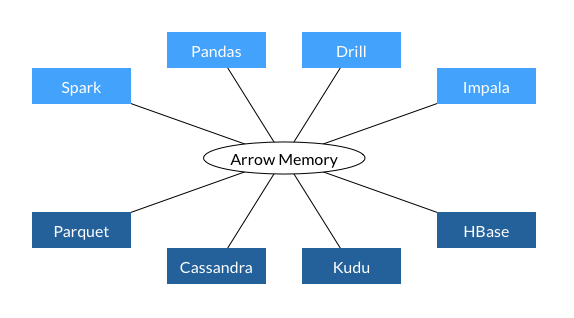



Instead of having to deploy a unique internal data format for every database and every programming language, employing costly serialization and deserialization to move data from one system to another, Arrow's in-memory columnar data format represents an out-of-the-box solution which allows systems that use or support Arrow to transfer data between them at little-to-no cost.

The larger Arrow project contains libraries that enable you to work with data in the Arrow columnar format in a variety of languages. Languages such as C++ and Java contain distinct implementations of the Arrow format, whereas the libraries in languages such as Python are built on top of the C++ library. In particular, Python uses the [`pyarrow`](https://arrow.apache.org/docs/python/index.html) library. These official libraries enable third-party projects to work with Arrow data without having to implement the Arrow columnar format themselves.

**How Does This Apply to 🤗 Datasets?:**

HF Datasets uses Arrow for its [local caching system](https://huggingface.co/docs/datasets/en/about_arrow#memory-mapping). Datasets are backed by an [on-disk cache](https://nordvpn.com/cybersecurity/glossary/disk-cache/#:~:text=Disk%20cache%20is%20a%20temporary,accessed%20information%20is%20readily%20available.), which is memory-mapped for fast lookup; in other words, HF Datasets treats each dataset as a memory-mapped file.

What is memory mapping? In short, we can understand memory mapping as a mapping between RAM and filesystem storage that allows the HF library to access and operate on elements of the dataset without needing to fully load it into memory. This how we are able to utilize MB of RAM for a dataset which is taking up GB of our disk space. If you're interested in learning about the more granular details of memory mapping, [this article](https://www.ibm.com/docs/es/aix/7.2?topic=memory-understanding-mapping) might be of some use.

Another major benefit of memory-mapped files is that such files can be shared across multiple processes, allowing us to parallelize the operations of `Dataset.map()` via the `num_proc` argument without needing to move or copy the dataset, for example.

#### **6.1.4: Saving disk space by streaming datasets**

$\textbf{Introduction:}$

To understand the point of [streaming datasets](https://huggingface.co/learn/nlp-course/chapter5/4?fw=pt#streaming-datasets), let's return to **The Pile**. If one tried to download this dataset in its entirety, one would require 825 GB of free disk space! To deal with situations where we need to access datasets as large as **The Pile** without comprising our RAM *or* storage space, HF Datasets provides a streaming feature which allows us to download and access elements on the fly, without needing to download the whole dataset.

To better understand how streamed datasets operate, let's stream in our PubMed Abstracts dataset. To do this, we simply have to pass `streaming = True` to our `load_dataset()` function.

In [ ]:
pubmed_dataset_streamed = load_dataset(
    "json", data_files=data_files, split="train", streaming=True
)

Instead of returning a familiar `Dataset`, streaming in our dataset has returned an `IterableDataset` object. Fortunately, an [`IterableDataset`](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.IterableDataset) object isn't too different from a `Dataset` object: it's simply a `Dataset` object backed by an iterable. As this description implies, to access the elements of an `IterableDataset` we need to iterate over it:

In [ ]:
# Accessing the first element of our dataset
next(iter(pubmed_dataset_streamed))

{'meta': {'pmid': 11409574, 'language': 'eng'},
 'text': 'Epidemiology of hypoxaemia in children with acute lower respiratory infection.\nTo determine the prevalence of hypoxaemia in children aged under 5 years suffering acute lower respiratory infections (ALRI), the risk factors for hypoxaemia in children under 5 years of age with ALRI, and the association of hypoxaemia with an increased risk of dying in children of the same age. Systematic review of the published literature. Out-patient clinics, emergency departments and hospitalisation wards in 23 health centres from 10 countries. Cohort studies reporting the frequency of hypoxaemia in children under 5 years of age with ALRI, and the association between hypoxaemia and the risk of dying. Prevalence of hypoxaemia measured in children with ARI and relative risks for the association between the severity of illness and the frequency of hypoxaemia, and between hypoxaemia and the risk of dying. Seventeen published studies were found that i

To process the elements of a streamed dataset on the fly, we can use the `IterableDataset.map()` function. The process of using this function is exactly the same as using the `Dataset.map()` function.

The real difference between `Dataset` and `IterableDataset` comes down to how we access elements in our streamed dataset.

For example, unlike `Dataset.shuffle()`, `IterableDataset.shuffle()` can only shuffle all the elements in a pre-defined `buffer_size`:

<pre><code class = "python">shuffled_dataset = pubmed_dataset_streamed.shuffle(buffer_size=10_000, seed=42)
next(iter(shuffled_dataset))
</code></pre>

Once an example is accessed, its spot in the buffer is filled with the next example in the corpus.

In place of `Dataset.select()`, we can use `IterableDataset.take()` and `IterableDataset.skip()`.

For example, to access the first 5 examples in the PubMed Abstracts dataset:

<pre><code class = "python"><b>Input:</b>
dataset_head = pubmed_dataset_streamed.take(5)
list(dataset_head)
</code></pre>

<pre><code class = "python"> <b>Output:</b>
[{'meta': {'pmid': 11409574, 'language': 'eng'},
  'text': 'Epidemiology of hypoxaemia in children with acute lower respiratory infection ...'},
 {'meta': {'pmid': 11409575, 'language': 'eng'},
  'text': 'Clinical signs of hypoxaemia in children with acute lower respiratory infection: indicators of oxygen therapy ...'},
 {'meta': {'pmid': 11409576, 'language': 'eng'},
  'text': "Hypoxaemia in children with severe pneumonia in Papua New Guinea ..."},
 {'meta': {'pmid': 11409577, 'language': 'eng'},
  'text': 'Oxygen concentrators and cylinders ...'},
 {'meta': {'pmid': 11409578, 'language': 'eng'},
  'text': 'Oxygen supply in rural africa: a personal experience ...'}]
</code></pre>

Similarly, you can use the `IterableDataset.skip()` function to create training and validation splits from a shuffled dataset as follows:

---

*Note: To create training and validation splits when working with `Dataset` objects, you should work with the [`Dataset.train_test_split()`](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) function.*

In [ ]:
# Generate a shuffled dataset
shuffled_dataset = pubmed_dataset_streamed.shuffle(buffer_size = 5000, seed = 50)

# Skip the first 1,000 examples, putting the rest into the training set
train_dataset = shuffled_dataset.skip(1000)

# Take the first 1,000 examples for the validation set
validation_dataset = shuffled_dataset.take(1000)

### **6.2: 🤗 Tokenizers**

$\textbf{Section Introduction:}$

This section will be dedicated to everything tokenization. First, we'll start out with an introduction to the WordPiece tokenization algorithm, a popular tokenization algorithm employed in many BERT-based Transformer models, such as DistilBERT. Having developed a basic understanding of WordPiece and tokenization algorithms in general, we'll move on to discussing how the HF Tokenizers library puts these tokenization algorithms into practice via its integration with the HF Datasets and (soon-to-be-introduced) HF Transformers libraries.

#### **6.2.1: WordPiece tokenization algorithm**

$\textbf{Introduction:}$

**Source:** [WordPiece Tokenization](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt#wordpiece-tokenization)

Originally developed by Google for pretraining BERT, the WordPiece tokenization algorithm is a popular tokenization algorithm which has been applied to a variety of BERT-based Transformer models.

We'll spend the first portion of this section explaining WordPiece from a theoretical perspective. In particular, we'll look at the "training algorithm" for generating a tokenized vocabulary using WordPiece before discussing how pre-tokenized words are actually tokenized using the generated vocabulary.

*   **Note:** We'll talk about pre-tokenization in more depth in Section 6.2.3, but the basic gist of this process is taking a sentence and (a) converting it to a list of individual words (e.g. for `sentence = 'This is a sentence.'`, `sentence` becomes `['This', 'is', 'a', 'sentence', '.']` and (b) generating offset mappings for each pre-token (e.g. in one type of offset mapping, the offset mapping for `This` would be `(0,3)`, indicating that `sentence[0]` is the first character in `This` while `sentence[3]` indexes the last character in `This`).

Unlike with training a deep neural network, tokenization training is a deterministic process. Note that WordPiece is an example of a **[subword tokenization algorithm](https://huggingface.co/docs/transformers/en/tokenizer_summary#subword-tokenization)**; subword tokenization algorithms have been demonstrated to be much more effective than full-word tokenization algorithms, and are in general the industry standard.

Finally, we'll actually code up WordPiece using a small corpus of text & a small final vocabulary size (i.e., not a practical application of WordPiece, but a demonstrative one).

---
*Note: Google technically never open-sourced its implementation of the training algorithm of WordPiece. What follows is an educated guess of the algorithm developed by HF based on published literature; as such, some of the finer details of the algorithm are likely missing in the demonstration to come.*


$\textbf{WordPiece training algorithm:}$

First, WordPiece starts off with a small vocabulary containing all of the model's special tokens and the initial WordPiece alphabet. This alphabet is generated by splitting each word into each of it's characters, appending the appropriate prefix (`##` for BERT) to every character except the first in each word. For example, `word` would be tokenized as such:

<pre>w ##o ##r ##d
</pre>

From here, WordPiece learns certain merge rules in order to build up the WordPiece vocabulary to its desired size (e.g., `##r` and `##d` might be merged into `##rd`, expanding the alphabet above to 5 tokens instead of 4). In particular, WordPiece calculates the following score for each pair of tokens, applying merges at each iteration of the training algorithm to the pair with the highest score:

$$score = \frac{freq\_of\_pair}{freq\_of\_first\_element \; \times \; freq\_of\_second\_element}$$

Instead of just merging the most frequent pairs, WordPiece specifically applies merges to tokens whose individual parts are less frequent in the vocabulary.

Thus the WordPiece training algorithm essentially constitutes taking a large corpus of text, generating the initial vocabulary by adding any special tokens to the initial alphabet generated from all of the words in the large corpus of text, and engaging in the iterative process of generating scores for each pair of vocab words & applying a merge rule to the pair with the highest score until the WordPiece vocabulary has been built up to the desired size. The final generated vocabulary is the output of the WordPiece training algorithm.

$\textbf{WordPiece tokenization algorithm:}$

Having generated our token vocabulary during the training portion of WordPiece, we can now finally tokenize our input text to our Transformer model. Starting from the first character of the pre-tokenized word we want to tokenize, WordPiece finds the longest subword that is in the vocabulary, then splits on it.

For example, suppose we are trying to tokenize the word `'bugs'` with the following vocabulary:

<pre>Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
</pre>

`'b'` is the longest subword starting at the beginning of this word, so WordPiece first tokenizes `'bugs'` as `['b', '##ugs']`. Then `'##u'` is the longest subword starting at the beginning of `'##ugs'` that is in the vocabulary, so we then tokenize this word as `['b', '##u', '##gs']`. Finally, `'##gs'` is the longest subword starting at the beginning of `'##gs'`, so our final tokenization of the word `'bugs'` ends up being the last list: `['b', '##u', '##gs']`.

Before we move on to actually implementing WordPiece, note that if the tokenization "inference" process gets to a stage where it’s not possible to find a subword in the vocabulary, then WordPiece tokenizes the whole word as unknown. For example, `'bum'` would get tokenized as `['[UNK]']` given the above vocabulary; even though we can start with `'b'` and `'##u'`, `'##m'` is not in our vocabulary.

$\textbf{Implementing WordPiece:}$

In this section, we'll actually implement WordPiece. First, let's start off with our corpus of text:

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Now, let's first compute the frequency of each word in this corpus as we apply the pre-tokenization process. Since WordPiece is popular in BERT-based Transformer models, we'll be using HF Transformers' [`bert-based-cased`](https://huggingface.co/google-bert/bert-base-cased) model for our pre-tokenization.

In [ ]:
from transformers import AutoTokenizer
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

word_freqs = defaultdict(int)
for text in corpus:
  words = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
  new_words = [word for word, offset in words]
  for word in new_words:
    word_freqs[word] += 1

word_freqs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

Now, let's generate our initial vocbaulary. Our initial vocabulary is composed of our initial alphabet as well as all of the special tokens utilized by the BERT Transformer model.

In [ ]:
alphabet = []
for word in word_freqs.keys():
  if word[0] not in alphabet:
    alphabet.append(word[0])
  for letter in word[1:]:
    if f"##{letter}" not in alphabet:
      alphabet.append(f"##{letter}")

alphabet.sort()

vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


Next, we split each word:

In [ ]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

splits

{'This': ['T', '##h', '##i', '##s'],
 'is': ['i', '##s'],
 'the': ['t', '##h', '##e'],
 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'],
 'Face': ['F', '##a', '##c', '##e'],
 'Course': ['C', '##o', '##u', '##r', '##s', '##e'],
 '.': ['.'],
 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'],
 'about': ['a', '##b', '##o', '##u', '##t'],
 'tokenization': ['t',
  '##o',
  '##k',
  '##e',
  '##n',
  '##i',
  '##z',
  '##a',
  '##t',
  '##i',
  '##o',
  '##n'],
 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'],
 'shows': ['s', '##h', '##o', '##w', '##s'],
 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'],
 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'],
 'algorithms': ['a',
  '##l',
  '##g',
  '##o',
  '##r',
  '##i',
  '##t',
  '##h',
  '##m',
  '##s'],
 'Hopefully': ['H', '##o', '##p', '##e', '##f', '##u', '##l', '##l', '##y'],
 ',': [','],
 'you': ['y', '##o', '##u'],
 'will': ['w', '##i', '##l', '##l'],
 'be': ['b', '##e

Now, we're ready for training. Below, we'll write two functions:

1.   The first function can be used to compute the score for each pair of subwords given the `splits` dictionary we generated above.
2.   The second function can be used to apply the appropriate merge rule to two subwords given the two subwords and the `splits` dictionary.

In [ ]:
def compute_pair_scores(splits):
  letter_freqs = defaultdict(int)
  pair_freqs = defaultdict(int)

  for word, freq in word_freqs.items():
    split = splits[word]
    if len(split) == 1:
        letter_freqs[split[0]] += freq
        continue
    for i in range(len(split) - 1):
        pair = (split[i], split[i + 1])
        letter_freqs[split[i]] += freq
        pair_freqs[pair] += freq
    letter_freqs[split[-1]] += freq

  scores = {
      pair : freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
      for pair, freq in pair_freqs.items()
  }

  return scores

def merge_pair(a, b, splits):
  for word in word_freqs:
    split = splits[word]
    if len(split) == 1:
      continue

    i = 0
    while i < len(split) - 1:
      if split[i] == a and split[i + 1] == b:
        merge = a + b[2:] if b.startswith("##") else a + b
        split = split[:i] + [merge] + split[i + 2:]
      else:
        i += 1
    splits[word] = split
  return splits

Now, we're ready to write our tokenization training loop. We're going to aim for a vocabulary size of 70:

In [ ]:
# Training algorithm
vocab_size = 70
while len(vocab) < vocab_size:
  scores = compute_pair_scores(splits)
  best_pair, max_score = "", None
  for pair, score in scores.items():
    if max_score is None or max_score < score:
      best_pair = pair
      max_score = score

  splits = merge_pair(*best_pair, splits)

  new_token = (
      best_pair[0] + best_pair[1][2:]
      if best_pair[1].startswith("##")
      else best_pair[0] + best_pair[1]
  )

  vocab.append(new_token)

# Final result
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut', '##ta']


Having finished and applied our WordPiece training algorithm, we can now write up our WordPiece tokenization algorithm.

In particular, we'll write up 2 functions:

1.   Given a word as input (and, implicitly, our vocabulary in `vocab`), this function will tokenize this word.
2.   Given an input text (e.g., a sentence), this function will tokenize the input.



In [ ]:
# Functions
def encode_word(word):
  tokens = []
  while len(word) > 0:
    i = len(word)
    while i > 0 and word[:i] not in vocab:
      i -= 1
    if i == 0:
      return ["[UNK]"]

    tokens.append(word[:i])
    word = word[i:]
    if len(word) > 0:
      word = f"##{word}"

  return tokens

def tokenize_text(text):
  pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
  pre_tokenized_text = [word for word, offset in pre_tokenize_result]
  encoded_words = [encode_word(word) for word in pre_tokenized_text]

  return sum(encoded_words, [])

# Let's try out our WordPiece tokenization algorithm on an example piece of text:
tokenize_text("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

#### **6.2.2: Understanding fast tokenizers**

$\textbf{Introduction:}$

**Source:** [Fast tokenizers’ special powers](https://huggingface.co/learn/nlp-course/chapter6/3?fw=pt)

🤗 provides access to two types of tokenizers: "slow" tokenizers -- tokenizers written in Python in the HF Transformers library -- and "fast" tokenizers -- tokenizers written in Rust which are provided through the HF Tokenizers library.

The performance between "slow" and "fast" tokenizers is oftentimes substantial. For example, going back to the Drug Review Dataset introduced in Section 6.1.2, HF researchers recorded the following times taken when tokenizing the entire aforementioned dataset:

\begin{array}{ccc}
  & \textbf{Fast tokenizer} & \textbf{Slow tokenizer} \\
  \hline
  \scriptsize{batched = True} & \small{10.8s} & \small{4min \; 41s} \\
  \scriptsize{batched = False} & \small{59.2s} & \small{5min \; 3s}
\end{array}

Beyond speed benefits (which often only come into play when tokenizing or otherwise performing operations on tons of text in parallel), "fast" tokenizers provide a variety of additional functionality which proves useful when pre-processing datasets and training LLMs for various NLP tasks.

In this section, we'll a brief tour of `BatchEncoding` objects and the variety of functionality that "fast" tokenizers backed by the HF Tokenizers library provides.

$\textbf{What are BatchEncoding objects?:}$

Instead of a simple Python dictionary object, the output of a "fast" tokenizer is a `BatchEncoding` object. A `BatchEncoding` object is a subclass of a dictionary which provides access to a variety of additional methods which "fast" tokenizers can take advantage of; you can find an exhaustive list of these various methods [here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/tokenizer#transformers.BatchEncoding).

Beyond parallelization, the key functionality of fast tokenizers is their generated *offset mappings* -- mappings between the original span of text and the tokens generated from them. Going beyond the basic example given in Section 6.2.1, "offset mappings" refers to a whole class of mappings, including:

*   mappings from each word to the token it generated, and vice versa; or
*   mappings from each character of the input text to the token it's inside, and vice versa.

Now, we'll take some time to look at a brief example in order to explore all of these different mappings and methods accessible to "fast" tokenizers.

In [ ]:
from transformers import AutoTokenizer

# Instantiating the tokenizer used in the bert-base-cased model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Example text
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."

# Generating tokens
encoding = tokenizer(example)

# Outputs
print(encoding)
print(type(encoding))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'input_ids': [101, 1422, 1271, 1110, 156, 7777, 2497, 1394, 1105, 146, 1250, 1120, 20164, 10932, 10289, 1107, 6010, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
<class 'transformers.tokenization_utils_base.BatchEncoding'>


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


First, and foremost, let's explore the output of our tokenizer. We see the following outputs generated:

1.   `input_ids`: These are the actual tokens generated from the input text provided to the tokenizer.
2.   `token_type_ids`: These IDs are only relevant for certain NLP tasks. For example, if one wanted to supervised fine-tune a model for generative question-answering, the input sequences provided to the model's tokenizer would contain both the question and desired answer. In this case, the `token_type_ids` would be used to differentiate between tokens belonging to the question text input (e.g., `0`) and the answer text input (e.g., `1`).
3.   `attention_mask`: As the name suggests, the value associated with this `BatchEncoding` key is the attention mask applied to the provided input sequence. Our model will attend to tokens whose `attention_mask` value is `1`, whereas our model won't attend to tokens assigned a value of `0`.

Note that the following output format isn't necessarily standard (excluding the `input_ids`, which are always generated). Certain models expect more or less ouputs from the tokenizer, so make sure that when you are instantiating a tokenizer using `AutoTokenizer.from_pretrained()`, the checkpoint you provide as input is the same as the checkpoint used to generate a model using `AutoModel.from_pretrained()` (we'll cover the latter function in Section 6.3).

Second, notice that our encodings are a `BatchEncoding` object, not a regular `dict` object (although the representations of both types of objects are quite similar).






As a quick note, it's always best to check the type of your instantiated tokenizer before attempting to acess any methods only available to "fast" tokenizers. In the case of the code above, we could check the type of the tokenizer by checking the tokenizer directly:

<pre><code class="python"><b>Input:</b>
tokenizer.is_fast

<b>Output:</b>
True
</code></pre>

or by checking the tokenizer's output, as follows:

<pre><code class="python"><b>Input:</b>
encoding.is_fast

<b>Output:</b>
True
</code></pre>

$\textbf{Important Methods of "Fast" Tokenizers}$

Now, let's explore some of the various methods accessible for use with a "fast" tokenizer. We list descriptions of the important methods in this text box, and then show their outputs below:

*   `tokens()`: This method returns the list of tokens at a given batch index; if only a single batch is provided, you don't need to specify any batch index. The list of tokens generated are the sub-parts of the input string generated after word/subword splitting but before conversion to integer indices (e.g., the final output of the WordPiece tokenization algorithm deployed in Section 6.2.1).

*   `word_ids()`: A list indicating the word corresponding to each token. Special tokens added by the tokenizer are mapped to `None` while other tokens are mapped to the index of their corresponding word; in relevant cases, several tokens will be mapped to the same word index.

*   `sentence_ids()`: A method which can be used to map a token to the sentence it came from. In our case, the `token_type_ids` returned by the tokenizer provide the same information, and so this method is unavailable for use upon the output of this particular tokenizer.

*   `word_to_chars()`: Give as input `batch_index` (if necessary) and `word_index`. To understand what `word_index` is, imagine for the sake of simplicitly that you've provided only a single input sequence to the tokenizer. Now, imagine generating a list from this input sequence of text where each list entry is a single word (or punctuation mark) from this input text; `word_index` is an integer you could use to index a single entry from this list. The output to this method is a `CharSpan` `NamedTuple` object of format: `(<index_of_first_character_in_original_string>, <index_of_last_character_in_original_string>)`. See the example below for further clarification.

*   `token_to_chars()`: Given as input `batch_index` (if necessary) and `token_index` (i.e., given the list generated by the `tokens()` method, `token_index` as in `tokens_list[token_index]`), this method returns the span of characters in the original string, or None, if the token doesn’t correspond to any characters in the original string. In particular, the output is a `CharSpan` object of the same `(<start>, <end>)` format as the output to the `word_to_chars()` method.

*   `char_to_word()`: Given as input `batch_index` (if necessary) and `char_index` (the index of a character in the original string), this method returns the index or indices of the associated encoded token(s). For example, if you provide as input the index associated with the character 'y' as in 'Sylvian' in the original string (as is done below), you'll get the relevant value from the `word_ids()` list. Another way to think about this output is the following: Take the original string and generate a list from it, specifically a list where each entry is a particular word (or punctuation mark) from this original string. If you indexed this list by the output generated from this method, you'd get the word the character whose index you provided to this method is associated with.

*   `char_to_token()`: Give as input `batch_index` (if necessary) and `char_index` (the index of a character in the original string). To understand the output, entertain the following example. Suppose you give as input the index associated with the character 'v' as in 'Sylvian' in the original string (as is done below). If you take the integer output and use it to index the list generated by the `tokens()` method, you'll get the token that character whose index you provided to this method is associated with.

Now, let's see the outputs of these various methods.


In [ ]:
# tokens()
print("\033[1mtokens():\033[0m ", encoding.tokens())

# word_ids()
print("\033[1mword_ids():\033[0m ", encoding.word_ids())

# word_to_chars()
start, end = encoding.word_to_chars(3)
print("\033[1mword_to_chars():\033[0m ", example[start:end])

# token_to_chars()
start, end = encoding.token_to_chars(10)
print("\033[1mtoken_to_chars():\033[0m ", example[start:end])

# char_to_word()
print("\033[1mchar_to_word():\033[0m \n \t \033[1mCharacter:\033[0m ", example[12], "\n \t (Not in output:) as in 'Sylvian'. \n\n \t \033[1mIndex:\033[0m ", encoding.char_to_word(12))

modified_example = example.split()[:-1]
modified_example.append(example.split()[-1][:-1])
modified_example.append(example.split()[-1][-1])

print("\n\t \033[1mmodified_example:\033[0m ", modified_example)
print("\n\n\t \033[1mIndexing modified_example By Output:\033[0m ", modified_example[encoding.char_to_word(12)], "\n")

# char_to_token()
print("\033[1mchar_to_token():\033[0m \n \t \033[1mCharacter:\033[0m ", example[14], "\n\t (Not in output:) as in 'Sylvian'. \n\n\t \033[1mOutput:\033[0m", encoding.char_to_token(14),"\n\n\t \033[1mIndexing encoding.tokens() By Output:\033[0m ", encoding.tokens()[encoding.char_to_token(14)])

tokens():  ['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']
word_ids():  [None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]
word_to_chars():  Sylvain
token_to_chars():  work
char_to_word(): 
 	 Character:  y 
 	 (Not in output:) as in 'Sylvian'. 

 	 Index:  3

	 modified_example:  ['My', 'name', 'is', 'Sylvain', 'and', 'I', 'work', 'at', 'Hugging', 'Face', 'in', 'Brooklyn', '.']


	 Indexing modified_example By Output:  Sylvain 

char_to_token(): 
 	 Character:  v 
	 (Not in output:) as in 'Sylvian'. 

	 Output: 6 

	 Indexing encoding.tokens() By Output:  ##va


#### **6.2.3: Walk-through of tokenization process**

$\textbf{Introduction:}$

**Source:** [Building a tokenizer, block by block](https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt)

Overall, the entire process of tokenization is composed of the following steps:

*   **Normalization:** During this step, we conduct any necessary cleanup, including removing spaces or accents, Unicode normalization, and the such. This step varies depending upon what type of input the particular model you're working with expects. We've haven't mentioned this process up until now, but as you can see, it's pretty self-explanatory.
*   **Pre-Tokenization:** Splitting the input into a list of words (and punctuation marks).
*   **Tokenization:** Running your pre-tokens through the (already-trained) tokenizer to generate batches of sequences of tokens.
*   **Post-Processing:** This process covers a variety of things, namely: adding special tokens to the tokenizer, and generating attention masks and token type IDs. We've seen bits of this step in what we've covered so far.

In this section, we're going to build up a tokenizer from scratch. This section will work as a good review of what we've discussed so far, and function as a good place to mention any of the fine details surrounding the tokenization process that we've neglected up to this point.

In order to construct our new tokenizer, we're going to use HF's `Tokenizer` class. This class contains the following submodules which we will use to build our new tokenizer:

*   `normalizers` => Contains all possible types of `Normalizers` you can use. A complete list of all `Normalizers` can be found [here](https://huggingface.co/docs/tokenizers/api/normalizers).
*   `pre_tokenizers` => Contains all the possible types of `PreTokenizer` you can use. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/pre-tokenizers).
*   `models` => Contains the various types of models you can use -- namely, `WordPiece`, which we'll be using. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/models).
*   `trainers` => Contains all the different types of `Trainer` you can use to train your model on a corpus. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/trainers).
*   `post_processors` => Contains the various types of `PostProcessor` you can use. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/post-processors).
*   `decoders` => Contains the various types of `Decoder` you can use to decode the outputs of tokenization (convert a list/array/tensor of integer token indices into words). A complete list can be found [here](https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt).



$\textbf{Generating our Corpus of Text:}$

In order to train our tokenizer, we'll be utilizing the [WikiText-2](https://huggingface.co/datasets/Salesforce/wikitext) dataset. In order to work with this dataset, we need to first instantiate the dataset before writing a [generator](https://www.programiz.com/python-programming/generator) function which can be used to iterate through the entire dataset; in particular, our generator will yield 1000 text sequences at a time. For future reference, HF Tokenizers tokenizers can be trained on text files directly; still, the generator approach will for our purposes be easier.

In [ ]:
from datasets import load_dataset

# Load in dataset
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split = "train")

# Generator
def get_training_corpus():
  for i in range(0, len(dataset), 1000):
    yield dataset[i : i + 1000]["text"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

$\textbf{Building a WordPiece tokenizer from scratch:}$

In line with the tokenization algorithm we demonstrated back in Section 6.2.1, here we practically implement a WordPiece tokenizer from scratch. In particular, we'll be building up the WordPiece tokenizer utilized in the BERT Transformer model.

Our general process will involve instantiating a `Tokenizer` object with a `model`, before setting its `normalizer`, `pre_tokenizer`, `post_processor`, and `decoder` attributes to the desired values.

---

*Note: When we instantiate our `Tokenizer` object with our `model`, we need to specify the `unk_token` so the model knows what to return when it encounters characters it hasn’t seen before.*

*Some additional arguments we could've passed to the model include:*
*   *`vocab` - Pass in the vocabulary of our model. Since we’re going to train the model, we don’t need to set this. For future reference, you can call the `get_vocabulary()` method on a HF Tokenizers tokenizer (such as one instantiated via the `load_pretrained()` method) to extract a tokenizer's vocabulary.*
*   *`max_input_chars_per_word` - This argument can be used to specify a maximum length for each word; words longer than this value are split.*



In [ ]:
# Imports
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [ ]:
# Instantiating Tokenizer object with model
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

Now, let's replicate a BERT tokenizer (in particular, the tokenizer utilized in the training of the `bert-base-uncased` model). Composing multiple normalizers via `normalizers.Sequence()`, we'll pass in the following normalizers: `NFD`, `Lowercase`, and `StripAccents`.

For reference, `normalizers.NFD()` is a NFD Unicode normalizer; without this normalizer, `normalizers.StripAccents()` won’t properly recognize the accented characters and thus won’t strip them out.

In [ ]:
# Adding a normalizer module to our tokenizer
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

# Test our normalizer by calling the normalize_str() method of the normalizer module
print("\033[1mTest String Output:\033[0m ", tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

Test String Output:  hello how are u?


Next, we build our BERT `pre_tokenizer` module from scratch. We use the `pre_tokenizer.WhitespaceSplit()` and `pre_tokenizer.Punctuation()` objects in sequence to do so.

In [ ]:
# Adding a pre-tokenizer module to our tokenizer
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
tokenizer.pre_tokenizer = pre_tokenizer

# Test our pre-tokenizer by calling the pre_tokenize_str() method of our tokenizer's pre_tokenizer module
print("\033[1mTest String Output:\033[0m ", tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")
)

Test String Output:  [('Let', (0, 3)), ("'", (3, 4)), ('s', (4, 5)), ('test', (6, 10)), ('my', (11, 13)), ('pre', (14, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]


Before we can train our tokenizer, we need to instantiate our tokenization trainer. In our particular case, we will be using `WordPieceTrainer`. The main thing to remember when instantiating a HF Tokenizers `Trainer` is to pass in all the special tokens you intend to use -- otherwise it won’t add them to the vocabulary, since they are not in the training corpus.

---

Note: Beyond `vocab_size` and `special_tokens`, we could have also passed in the following arguments:
*   `min_frequency` - Set the minimum number of times a token must appear to be included in the vocabulary.
*   `continuing_subword_prefix` - If we want to utilize something different from `##`, we can set the desired string here.



In [ ]:
# Loading in our tokenizer's Trainer
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

With our `Trainer` object instantiated, we can train our `tokenizer` by simply calling the `train_from_iterator()` method, passing in our generator function as well as our `Trainer` object:

In [ ]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

If we wanted to, we could now test our tokenizer by calling its `encode()` method. For example:

<pre><code class="python"><b>Input: </b>
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)
</code></pre>

<pre><code class="python"><b>Output: </b>
['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']
</code></pre>

Note that the `encoding` we've generated contains all the necessary outputs of the tokenizer in its various attributes: `ids`, `type_ids`, `tokens`, `offsets`, `attention_mask`, `special_token_masks`, and `overflowing` (`special_token_masks` is self-explanatory, and `overflowing` is something we'll discuss later).

Now, we'll add a `post_processor` module to our tokenizer. In order to create our post-processor, we need to use a `TemplateProcessor` object.

For our `TemplateProcessor` object, we need to specify how to treat a single sentence and a pair of sentences. For our post-processor, we want to add the `[CLS]` token at the beginning and `[SEP]` token at the end of each sentence, or after each sentence (in the case of pairs of sentences being included in a single input sequence). To do this, note the following:
*   The first (or single) sentence is represented by `$A`, while the second sentence is represetned by `$B$`.
*   For each of these (special tokens and sentences), we also specify the corresponding token type ID after a colon.



In [ ]:
# Get the token IDs associated with our [CLS] and [SEP] tokens
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

# Add a post_processor module to our tokenizer
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

Now, let's add a `decoder` module to our tokenizer.

In [ ]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

We could stop here. If you wanted to do so, you can save your tokenizer in a single JSON file as follows:

<pre><code class="python">tokenizer.save("tokenizer.json")
</code></pre>

Now, you can reload that file in a `Tokenizer` object with the `from_file()` method:

<pre><code class="python">new_tokenizer = Tokenizer.from_file("tokenizer.json")
</code></pre>

If you want to be able to use this tokenizer in HF Transformers (the topic of our next section), our actual last step will be wrapping our tokenizer in a `PreTrainedTokenizerFast`. To do so, we can either pass the tokenizer we built as a `tokenizer_object` or pass the tokenizer file we saved as `tokenizer_file`. The key thing to remember is that we have to manually set all the special tokens.

In [ ]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


And that's it! Now, you can use your tokenizer like any other 🤗 Transformers tokenizer. If you want, you can save this tokenizer using the [`save_pretrained()`](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/model#transformers.PreTrainedModel.save_pretrained) method.

### **6.3: 🤗 Transformers: Behind the Pipeline API**

$\textbf{Section Introduction: }$

While the 🤗 Datasets and 🤗 Tokenizers are going to be crucial libraries for preparing your datasets and input text for any variety of NLP tasks, the 🤗 Transformers library will be your main go-to library when working with Transformers and LLMs. HF hosts over [900,000 models](https://huggingface.co/docs/hub/en/index) (including Transformer-based models, CNNs, RNNs, etc.), which are accessible via the [Model Hub](https://huggingface.co/models). In order to utilize and create your own HF Transformer models, you will be using the 🤗 Transformers library.

The most basic object in the 🤗 Transformers library is the `pipeline()` function. This function connects a model with its necessary preprocessing and postprocessing steps, allowing you to directly input any text & receive an intelligble answer. For example, let's use the `pipeline()` function for the following simple extractive QA task:

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'score': 0.6949766278266907, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

You can customize the basic `pipeline()` function in a variety of ways; for example, you can pass in a string to the `model` argument to specify (in the above case) a specific NLP model fine-tuned for QA tasks, or pass a Boolean value to `use_fast` to specify whether or not you want to use a "fast" tokenizer. A complete documentation can be found [here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/pipelines#transformers.pipeline) (scroll to the bottom of the linked-to section).

In this section, we're going to be looking at how to use the 🤗 Transformers library in order to essentially re-create the results we can get from the baseline `pipeline()` function. In our progress towards this task we'll learn how to integrate 🤗 Datasets and 🤗 Tokenizers library with the 🤗 Transformers library in order to utilize HF's NLP capabilities to its fullest extent.

#### **6.3.1: Using models with 🤗 Transformers**

$\textbf{Introduction: }$

**Source:** https://huggingface.co/learn/nlp-course/chapter2/3?fw=pt

In this section, we're going to look at the variety of different methods available to us for loading in and saving our HF models.

In general, when loading in HF models you'll want to utilize the `AutoModel` class. In particular, you'll oftentimes be using a particular "variation"/version of this class depending upon the particular task you are trying to instantiate a model for (e.g. `AutoModelForQuestionAnswering` if you want to load in a NLP model trained for QA tasks); these particular variations essentially amount to adding different "heads"/re-configuring the final layer of the model depending upon what task you want to train the model for (e.g., a binary sentiment analysis model only requires that the final layer of the model contain two logit-producing neurons).  

The `AutoModel` class and all of its relatives are simple wrappers over the wide variety of pre-trained models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture configuration for your checkpoint, and then instantiates a model with this architecture; all you'll have to do is pass in a string specifying the particular model checkpoint you want (e.g. `bert-base-uncased`).

The important thing to understand about the `AutoModel` class is that it's just a shortcut command. Behind the scenes, the library has one model class per combination of architecture plus class/"variation". For example, if you call the `AutoModelForSequenceClassification` class using the model `"distilbert-base-uncased-finetuned-sst-2-english"`, this class will actually instantiate a `DistilBertModel` class -- in particular, the `DistilBertForSequenceClassification` class.

$\textbf{Loading in a Model: }$

Now, let's initialize a BERT model. To do so, we must instantiate its configuration before passing this configuration in as a model argument into the appropriate mode class (in this case, we want `BertConfig` and `BertModel`). Using this approach, we automatically randomly initialize the weight and bias neurons of our model architecture.

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()
print(config)

# Building the model from the config
model = BertModel(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In order to load in a pre-trained BERT model, we will instead want to use the `from_pretrained()` method. Instead of passing in a `BertConfig` object, we'll instead pass in the `bert-base-cased` identifier.

By utilizing the `from_pretrained()` method, we've now loaded a BERT model with the weights associated with the `bert-base-cased` model checkpoint. As a pre-trained model, we can use this model for inference purposes for the tasks it was trained on, or fine-tune this model for a separate task. By training with pretrained weights rather than from scratch, we can quickly achieve good results (and without significant data or computational cost, relative to pre-training our BERT model from scratch at least). You can find out more about the specifics of the `bert-base-cased` model checkpoint by reading its [model card](https://huggingface.co/google-bert/bert-base-cased).

Note that the identifier used to load the model can be the identifier of any model on the Model Hub, as long as it is compatible with the BERT architecture. To find a complete list of all such models, see [here](https://huggingface.co/models?other=bert&sort=trending).

---

*Note: The URL linked to "here" is as follows:*

<pre>
https://huggingface.co/models?other=bert&sort=trending
</pre>

*To search for all models that are compatible with, say, the DistilBERT architecture, modify the above url as follows:*

<pre>
https://huggingface.co/models?<b>other=distilbert</b>&sort=trending
</pre>

*To see a complete list of all models you could modify the above "other" tag with, go to the [🤗 Transformers documentation](https://huggingface.co/docs/transformers/index) and search under "Models" > "Text Models".*

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

$\textbf{Saving Our Model: }$

In order to save our above model, we simply use the `save_pretrained()` method in a manner such as the following:

<pre><code>model.save_pretrained("directory_on_my_computer")
</code></pre>

Doing so will save the following files into the specified directory:

<pre>(1) config.json
(2) model.safetensors</pre>

The *config.json* file will include all attributes necessary to build the model architecture. This file will also contain some additional metadata, such as where the checkpoint originated and what 🤗 Transformers version you were using when you last saved the checkpoint

The *model.safetensors* file is our state dict -- that is, it contains all of our model weights. If you're interested in learning more about the Safetensors file format, you can start reading up about it [here](https://huggingface.co/docs/safetensors/en/index).

#### **6.3.2: Using tokenizers with 🤗 Transformers**

$\textbf{Introduction: }$

**Source:** https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt#tokenizers

In this section, we'll be looking at how to work with tokenizers in the 🤗 Transformers library.

We've already worked with tokenizers extensively in Section 6.2 (in fact, Section 6.2.3 was all about building a tokenizer from scratch which could *also* be integrated with the HF Transformers library). The main difference between Section 6.2 and this section is that while we only covered methods available to "fast" tokenizers in Section 6.2, the methods covered here are available to both "fast" *and* "slow" tokenizers. Most of time you are (and should be) working with "fast" tokenizers; still, it's useful to know the following general methods.

$\textbf{Loading and Saving a Tokenizer: }$

We can easily load and save our tokenizers with the same two methods we use for our models: `from_pretrained()` and `save_pretrained()`. When saving our tokenizer, we're essentially saving both the algorithm used (similar to the *architecture* of a model) as well as the vocabulary (similar to the *weights* of a model).

Let's load in below a BERT tokenizer trained with the same checkpoint as the BERT model we looked at the in the previous section. Similar to the `AutoModel` and `BertModel` classes, there are the `AutoTokenizer` and `BertTokenizer` classes, respectively. Unlike the former classes, though, there is relatively less variety in the number of tokenizer classes available; additionally, whereas you might be inclined to use `AutoModelForSequenceClassification` or `AutoModelForQuestionAnswering` depending upon which task you are trying to fine-tune a pre-trained model on, you generally just use the `AutoTokenizer` (or, in our case as well, `BertTokenizer`) class.

In [ ]:
from transformers import AutoTokenizer

# Loading our tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenizer inference on an example input sequence
tokenizer("Using a Transformer network is simple")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

To save our tokenizer, we'd run something like the following:

<pre><code>tokenizer.save_pretrained("directory_on_my_computer")
</code></pre>

$\textbf{Common Tokenization Methods Available in the HF Transformers Library}$

In general, you'll simply be calling the tokenizer directly on your inputs. Still, we dedicate this section to a brief review of some common tokenization methods applicable to HF Transformers-supported tokenizers which you may encounter outside of this notebook (and, in fact, have already encountered in previous sections).

Generally speaking, the *encoding* process (i.e., the process of encoding input text into a sequence of numbers) is two-fold. First, you translate your input sequence into a list of tokens via the tokenizer's `tokenize()` method. Finally, you'll convert your list of tokens into a sequence of numbers/input IDs via the tokenizer's `convert_tokens_to_ids()` method. Let's quickly try it out:

In [ ]:
from transformers import AutoTokenizer

# Load in the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenize an input sequence
sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)
print("\033[1mTokens:\033[0m ", tokens)

# Convert our tokens to numbers/input IDs
ids = tokenizer.convert_tokens_to_ids(tokens)
print("\033[1mNumber IDs:\033[0m ", ids)
  # These IDs are currently stored in a list. You'll want to convert this list of IDs into a torch.Tensor in order to
  # actually work with them.

Tokens:  ['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']
Number IDs:  [7993, 170, 13809, 23763, 2443, 1110, 3014]


In order to decode a sequence of vocabulary indices back into the original string, we can simply call the tokenizer's `decode()` method.

Note that the `decode()` method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be useful when we use models that predict new text.

Let's look at a quick example to wrap up this section:

In [ ]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


#### **6.3.3: Additional details: padding, attention masks, and more**

$\textbf{Introduction: }$

Start here...

In [ ]:
# REMOVE ONCE DONE: https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt

#### **6.3.4: Putting everything together: A simple example**

In [ ]:
# https://huggingface.co/learn/nlp-course/chapter6/3b?fw=pt

### **6.4: An Example: HF Accelerate**

In [ ]:
# Continuing in line with our discussion of BERT-based Transformer models
# https://huggingface.co/learn/nlp-course/chapter7/3?fw=pt#fine-tuning-a-masked-language-model

## **Section 7: Fine tuning**

Language models are great at performing general tasks - Q/A, summerization, popular coding languages - but sometimes we want it to do a task that was not well-represented (or represented at all) during pre-training.

As such, fine tuning becomes an option.  We feed our LM data corresponding to the task that we want it to learn with the hope of improvement.

The problem is, though, that even if the LM *can* learn the task (which is not always given in real-world problems), it can still be very expensive computationally and time-wise.  

So unless you're OpenAI, you might not have the resources to fully fine-tune a model.  Thus, in this section, we'll go through some ways which we can fine-tune efficiently while still improving model performance.

### **7.1: Quantization**

If you know a little about computer systems, then you know that not all numbers are created equal on a computer.  Since computers operate in binary, every number on a computer has a binary representation, but we need to know how long that binary number is for storing purposes.

Every 1 or 0 in a binary number is called a "bit" in the context of a computer.  A number is classified based on how many bits it has; since we're in binary, that number is usually classified in terms of powers of two.

Thus, we get to the types of numbers:

*   int4
*   int8
*   fp16 (fp is "floating point")
*   fp32
*   fp64

Where the number is the amount of bits of memory it will take.  If our number in question is not represented by exactly this many bits (which is most numbers), we reserve the amount of memory of the next highest power of two.  As an example, if our number in question has 10 bits, we save it as a fp16.

Lastly, note that int numbers do not have a decimal representation in base 10 (the numbers we're used to), which floating point, or fp, numbers do.

Why are we going though systems programming stuff in a LM course?

Because most of the time, LLM's parameters come in fp32, meaning they are really accurate, but they take up quite a bit of space.

Quantization is the provocess of loading the parameters in a different level of accuracy, like fp16 or int8.

By quantizing, we reduce the memory footprint, but we reduce the precision, so the attention calculations might not be the same as if it were in fp32.

Nevertheless, quantization is a neccesity in most situations where there aren't enough GPUs to train a model in fp32

### **7.2: Parameter Efficient Fine Tuning (PEFT)**

Our models very capable and have a lot of ability even before fine tuning.  As such, we don't neccessarily need to retrain the entire models.

Parameter-efficient fine tuning (PEFT) is an umbrella term for various techniques that help train our model efficiently.  In this section, we'll cover the popular types.

#### **7.2.1: Sparse Fine tuning**

Since there is already so much ability encoded in the models, it doesn't make sense to adjust every single parameter, especially if they number in the billions.

Sparse fine tuning follows this idea by only training a certain percent of parameter - the exact percent may vary from 0.1% - 20% and could in theory by any percentage.  Of course, though, it becomes more expensive to train a higher percent of parameters, but you might see better model performance as a result.

We can choose which parameters in a couple of ways:


*   Randomly: we select x% of parameters arbitrarily and freeze the rest
*   Layer-based:  we only train the last couple of attention layers and freeze the rest
*   Gradient-based: We train the top x percentile of parameters ranked by size of gradient during warmup steps. (warmup steps are when we use a smaller learning rate during a fixed number of steps at the start in order to not make any crazy jumps to begin with)
*    Fisher information matrix: while it's a whole topic in and of itself, for our purposes, we can use Fisher information to measure which parameters play a bigger role in the predictions.

There are many others, mostly coming from the field of mechanistic interpretability, where AI scientists try to figure out the interinsic importance and function of LM parameters.



#### **7.2.2: Low Rank Adaptation (LoRA)**

Low Rank Adaptation, or LoRA is the brilliant idea that the matrices of model weights learned during training have a low "intrinsic rank", meaning that the matricies' learned during training do not need full linear independance.

If you don't know about the concept of "rank" in linear algebra, then you probably won't fully understand the inutition of LoRA, which is ok.  If you're curious though, I'll save you a google search and put the wikipedia article here: https://en.wikipedia.org/wiki/Rank_(linear_algebra)

The first step in LoRA is freezing the model weights, $W_i$.

Our goal is to train a $\Delta W$, which encodes the changes in weights that will tune our model to the desired task.

In this $\Delta W$, however, there isn't a full rank, instead, if $W \in \mathbb{R}^{d_1 \ \times \ d_2}$, then $\Delta W = AB$ where $A \in \mathbb{R}^{d_1 \ \times \ r}, \ B \in\mathbb{R}^{r \ \times \ d_2} \text{ and } r << d_1, d_2$ - $r$ being the rank that we project down to.

Thus our final fine-tuned weights are $W_{f} = W_i + \Delta W$

Since our $W_i$ is frozen, we are only really training $\Delta W$, and since $\Delta W$ has $d_1 \times r + r \times d_2$ parameters, while $W_i$ has $d_1 \times d_2$ parameters.  Thus, with a well-chosen $r$, we could be significantly decreasing the amount of parameters that we need on our GPU.

Note that, though we are adding more weights, only the trainable weights, $\Delta W$, go on our GPU, while the $W_i$ can stay on our hard drive, not affecting memory.

More details, including the initializaiton of $A$ and $B$ can be found in the og paper: https://arxiv.org/pdf/2106.09685

#### **7.2.3: Adapters**

But what if we didn't need to adjust the model weights themselves at all?  What if instead, we just nudged our output towards the desired task.

That's the idea behind adapters, which actually predates LoRA.

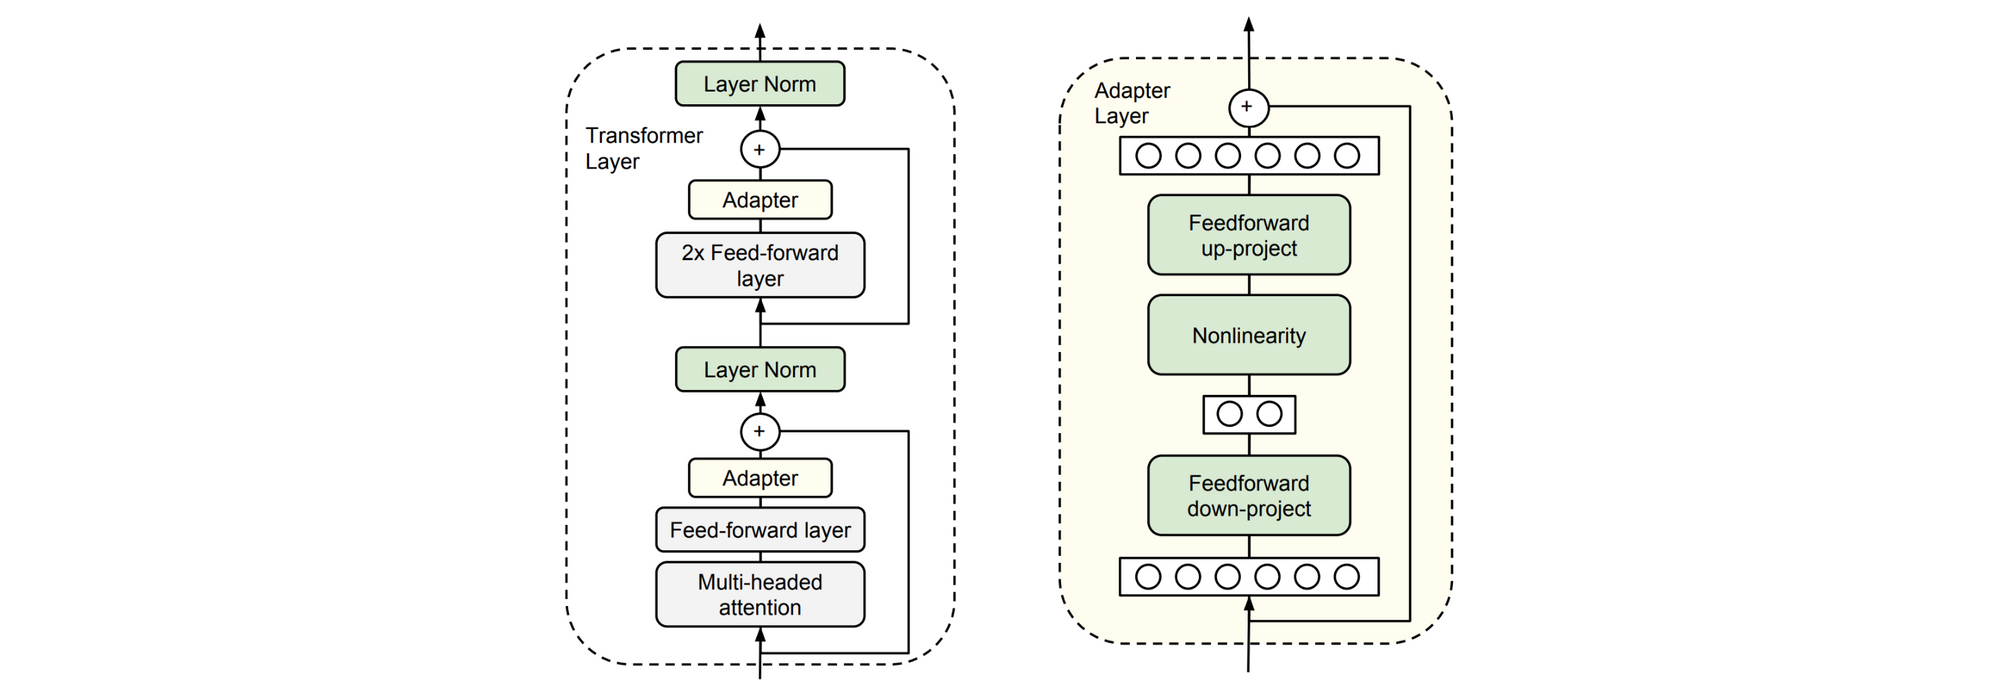

We can see from the diagram that adapters are just two later neural networks which also project to a lower rank.

In training, we freeze the models weights and only tune the adapter, which is of course, much cheaper than fine tuning the whole model becasue of the adapter's down projection to a lower dimension.

The problem with adapters, though, is that you're adding weights to a model, so though it's cheap and fast during training when you only deal with the adapter weights, during inference, you deal with all the LM's weights including the adapters', thus adding latency to inference.  See the LoRA paper for more details.

### **7.3: Retrieval Augemented Generation (RAG)**

Retrieval Augemented Generation, henceforth RAG, is how we give language models access to novel content without breaking the bank fine tuning.

RAG is used for giving a LM domain-specific content that either wasn't represented well in training or information that it'd have no idea of to begin with.

For example consider:
*   A company's private manual on how to operate their machines
*   A politician's most recent speech
* Kant's "The Metaphysics of Morals"

For the companies manual, the LM probably never saw it in pre-training; the politician's most recent speech probably wasn't included in the LM's training data based on recency alone; and though the LM probably read Kant and the corresponding sparknotes during pre-training, it likely won't be able to answer really specific questions about "The Metaphysics of Morals".  In fact, it might be liable to hallucinate in these cases.

Instead of just aquainting the model to these concepts through training, why don't we just automoatically feed the model what it needs to know?

Though this idea may seem circular, if we have access to the corpus of text that hold the answer to our question, we should try to make sure that the model can analyse that text for us.  Thus, the problem comes down to retrieval.  How can we give our model the passage with the most relevant information every time?

Here's how we do it:

1.   We start with a large corpus of text or images.  Our first step is to partition that corpus down to smaller chunks if it's too big.  We can do by set rules, e.g. 500 words, 10 sentences, on every line break, or we can have a semantic chunker which parses the text into semantically significant blocks.  The latter suggestion is more computationally expensive, but is more likely to lead to better results.
2.   We create a vector representation of the chunks of text.  Going back to 1.2, we can use sentence transformers or other vectorizers that will return a semantically significant numerical representation.  Make sure that the chosen text-to-vector model to do this step stays consisten thoughout the process.
3.  Now, once we have a database of vector-chunk pairs, we can ask the model a content-specific
question, like "What is the company's policy on downloading outside software on the os?", "What was Ms. Politician's stance on lowering income tax?", or "what were Kant's major points on punative justice in 'The Metaphysics of Morals'?"
4. We then use the same text-to-vector tool to vectorize our question.
5. We compare the question vector with every vector in the vector-chunk database by doing something called **cosine similarity**, which is when given vectors $a, b \in \mathbb{R}^n$, the cosine similarity between $a$ and $b$ is $\frac{a \cdot b}{|a||b|}$.  The cosine similarity essentially measures how semantially similar the vectors are, as the name would imply.
6. We then rank chunks based on cosine similarity and choose the top $k$ chunks with the highest similarities to the question.  $k$ is a hyperparameter to be chosen by the user.
7.  Lasty, we tack those chunks onto our questions for the lanugage model, so we're essentailly providing the neccesary information in our question.




Note, though, that this method is heavily dependant on the the strength of the text-to-vector model.  If it's weak, the chunks of text that you'll be feeding the model may not actually correspond to what you wanted to know about.  Also, if your question doesn't contain enough domain-specific words, then you're question vector may not pick out the specific chunks you were hoping for.

Despite this flimsiness, we can make sure that there's a cosine similarity limit to be returned, or even ask the model to refuse answering if the provided chunks do not answer the question.

All in all, RAG is usually the best option when you want your LM to have domain-specific data, but fine-tuning your model on that data is not productive.

### **7.4: Prompt engineering**

Prompt engineering the the art of changing your prompt to the LM in order to exhibit the desired behaviors.

While prompt engineering may sometimes feel tedious, certain models are volatile in their answers with even just a few words changed.  Therefore, we can sometimes avoid the need for finetuning with a well-chosen choice of words.

Though you may not see it in LLM webapps, there are actually two prompts in every query: the system prompt and the user prompt.

The **system prompt** is meant to give broad instructions about how the LLM should behave.  In the system prompt, we give general instructions to our LLM how they should answer, what they should refuse to answer, and their purpose.

For example, a system prompt might look like this:

"You are a fast food worker chatbot; your goal is to take orders form the drive through and send them to the kitchen.  Here is the menu that people will order from, the price of each item, the ingredients, the customizable options, and how long it usually takes:

\<the menu\>

You will also ask follow up questions if the customer would like to order additional food when it relates to the order, e.g. 'would you like fries with that?'.

Ask any other questions until the order is complete, upon which you thank them, give them their total, and tell them an ETA for the food.

Be kind and patient, but don't answer any questions unrelated to the food."

We don't give our end user access to this prompt becasue (1) we don't want them to mess with out model's behavior, and (2) they probably don't care how we instructed our model as long as it works as intended.

The other prompt, the **user prompt** is what the end user actually asks, like "Can I have a large cheese burger with no tomatoes, large fries, and a coke with no ice, please?"

To put it in perspective, you are giving the user prompt when you ask something to Chat GPT or Claude Sonnet.

There are certain methods you can use to improve your prompting.  I'll list a few that certainly do not cover the myriad of possible techniques.


*   Role assignment.  Starting with "You are \<some role\>"
*   Using caps to emphasise certain points, like DO NOT ANSWER ANY UNRELATED QUESITONS
*   Asking the LM to "think step by step" or "explain your reasoning" which takes advantage of the auto-regressive nature of these models.  This mehtod is also called "Chain of Thought"
*   Being kind to the model
*   Giving the model examples also helps direct it's behavior.  These examples are also called "shots", so two-shot would be providing the model with two examples of input-output, and zero-shot is no exmaple.

As of now, there is no exact science behind prompt engineering , though mechanistic interpretability people spend a lot of time trying to figure out which changes in the prompt lead to which changes in the output.


There are many, many prompt engineering tricks which you accumulate though experience.  Because I am not the most experienced, I'll be a cop out and provide a resource with a catelog of a lot of popular methods: https://www.promptingguide.ai/